## Dataset

This section handles the loading and initial preparation of the MNIST dataset. MNIST contains 28x28 pixel grayscale images of handwritten digits (0-9).

**Key Operations:**

1.  **Data Loading (`load_mnist_images`, `load_mnist_labels`):**
    *   These functions read the MNIST dataset from its specific binary file format.
    *   Image data is reshaped to `(num_images, rows, cols)`.

2.  **One-Hot Encoding Labels:**
    *   For multi-class classification with a softmax output and categorical cross-entropy loss, integer labels (e.g., digit `5`) are converted into a one-hot vector format (e.g., `[0,0,0,0,0,1,0,0,0,0]` for 10 classes).
    *   This represents the true label as a probability distribution where the correct class has a probability of 1.

<figure style="text-align:center;">
    <img src="images/mnist_digits.png", style="border-radius:20px;", width="50%">
    <figcaption>Samples from the MNIST dataset</figcaption>
</figure>

In [8]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Leggi intestazione: magic number, numero immagini, righe, colonne
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Leggi tutti i pixel e convertili in array numpy
        images = np.frombuffer(f.read(), dtype=np.uint8)
        # Ridimensiona l'array in (num_images, rows, cols)
        images = images.reshape((num_images, rows, cols))
    return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

#-------------- Data Extraction ---------------------------
train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
train_labels = load_mnist_labels('MNIST/train-labels-idx1-ubyte')

test_images = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
test_labels = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')

#--------------- Train data manipulation ------------------
print(train_images.shape)  # (60000, 28, 28)
print(train_labels.shape)  # (60000,)

one_hot_labels = np.zeros(train_labels.shape[0]*10).reshape((train_labels.shape[0]),10)
for i in range(len(train_labels)):
    one_hot_labels[i][train_labels[i]]=1
train_labels = one_hot_labels

print(train_labels.shape) # (60000,10)

#--------------- Test data manipulation -------------------
print(test_images.shape)  # (10000, 28, 28)
print(test_labels.shape)  # (10000,)

one_hot_labels = np.zeros(test_labels.shape[0]*10).reshape((test_labels.shape[0]),10)
for i in range(len(test_labels)):
    one_hot_labels[i][test_labels[i]]=1
test_labels = one_hot_labels

print(test_labels.shape) # (10000,10)

(60000, 28, 28)
(60000,)
(60000, 10)
(10000, 28, 28)
(10000,)
(10000, 10)


## PyTorch CNN Model Architecture

A Convolutional Neural Network (CNN) is defined using PyTorch's `nn.Module` to serve as a reference and source of pre-trained weights.

**Architecture (defined as `SimpleCNN` class):**

1.  **Conv1 + ReLU1:** `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)`
    *   Input: `(B, 1, 28, 28)`
    *   Output dimension: $O = \lfloor \frac{(I - K + 2P)}{S} \rfloor + 1 = \lfloor \frac{(28 - 2 + 0)}{2} \rfloor + 1 = 14$
    *   Output: `(B, 32, 14, 14)`

2.  **Conv2 + ReLU2:** `nn.Conv2d(32, 64, 2, 2, 1)`
    *   Input: `(B, 32, 14, 14)`
    *   Padded input dimension: $14 + 2*1 = 16$
    *   Output dimension: $O = \lfloor \frac{(16 - 2 + 0)}{2} \rfloor + 1 = 8$
    *   Output: `(B, 64, 8, 8)`

3.  **Conv3 + ReLU3:** `nn.Conv2d(64, 128, 2, 2, 0)`
    *   Input: `(B, 64, 8, 8)`
    *   Output dimension: $O = \lfloor \frac{(8 - 2 + 0)}{2} \rfloor + 1 = 4$
    *   Output: `(B, 128, 4, 4)`

4.  **Flatten:** `nn.Flatten()`
    *   Input: `(B, 128, 4, 4)`
    *   Output: `(B, 128 * 4 * 4)` which is `(B, 2048)`

5.  **FC1 + ReLU4:** `nn.Linear(in_features=2048, out_features=250)`
    *   Input: `(B, 2048)`
    *   Operation: $Y = XW^T + b$
    *   Output: `(B, 250)`

6.  **FC2:** `nn.Linear(in_features=250, out_features=10)` (Output layer)
    *   Input: `(B, 250)`
    *   Output: `(B, 10)` (logits for 10 classes)

<figure style="text-align:center;">
    <img src="images/cnn.png", style="border-radius:20px;", height=300>
    <figcaption>CNN Architecture (B: Batch size)</figcaption>
</figure>

### Model and Dataset Declaration with Training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from tqdm import tqdm

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # --------- Convolutional Layers ------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        # ---------- Flatten to become MLP's input -----------
        self.flatten = nn.Flatten()
        fc_input_size = 128 * 4 * 4
        # ---------- Multi Layer Perceptron ---------------
        # Only one hidden layer for classification
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=250)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)

    def forward(self, x):
        # First convolution: from 1x1x28x28 to 1x32x14x14
        x = self.conv1(x)
        x = self.relu1(x)
        # Second Convolution: from 1x32x14x14 to 1x64x8x8
        x = self.conv2(x)
        x = self.relu2(x)
        # Third Convolution: from 1x64x8x8 to 1x128x4x4
        x = self.conv3(x)
        x = self.relu3(x)
        # Flatten
        x = self.flatten(x)
        # MLP
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x
    
# No bias version of the model
class SimpleCNN_no_bias(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN_no_bias, self).__init__()

        # --------- Convolutional Layers ------------
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=2, stride=2, padding=0, bias=False)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=1, bias=False)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2, padding=0, bias=False)
        self.relu3 = nn.ReLU()
        # ---------- Flatten to become MLP's input -----------
        self.flatten = nn.Flatten()
        fc_input_size = 128 * 4 * 4
        # ---------- Multi Layer Perceptron ---------------
        # Only one hidden layer for classification
        self.fc1 = nn.Linear(in_features=fc_input_size, out_features=250)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=250, out_features=num_classes)

    def forward(self, x):
        # First convolution: from 1x1x28x28 to 1x32x14x14
        x = self.conv1(x)
        x = self.relu1(x)
        # Second Convolution: from 1x32x14x14 to 1x64x8x8
        x = self.conv2(x)
        x = self.relu2(x)
        # Third Convolution: from 1x64x8x8 to 1x128x4x4
        x = self.conv3(x)
        x = self.relu3(x)
        # Flatten
        x = self.flatten(x)
        # MLP
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# # 2.------------------ CNN's Dataset declaration ----------------------

# class CNNDataset(Dataset):
#     def __init__(self, digits, labels, transform=None):
#         assert len(digits) == len(labels), "Number of digits and labels doesn't match"
#         self.digits = digits
#         self.labels = labels

#     def __len__(self):
#         return len(self.digits)

#     def __getitem__(self, idx):
#         digit = self.digits[idx]
#         label = self.labels[idx]
#         digit = digit.unsqueeze(0) # Needed operation to add the dimension of greyscale images (28,28) -> (1,28,28)
#         return digit, label

# tri = torch.from_numpy(train_images).float() / 255
# trl = torch.from_numpy(train_labels).float()
# tsi = torch.from_numpy(test_images).float() / 255
# tsl = torch.from_numpy(test_labels).float()

# train_dataset = CNNDataset(tri,trl)
# test_dataset = CNNDataset(tsi,tsl)

# batch_size = 128
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # 3.------ Training Setup ---------------

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# print(f"device: {device}")

# model = SimpleCNN(num_classes=10).to(device)

# # Loss definition
# criterion = nn.CrossEntropyLoss() 

# # Optimisation definition
# learning_rate = 0.001
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num_epochs = 5 

# # 4.------- cycle training ------

# print("\nStarting Training...")
# for epoch in range(num_epochs):

#     model.train() 

#     running_loss = 0.0
#     start_time = time.time()
#     #tqdm is module used to have a progress bar
#     progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

#     for inputs, labels in progress_bar:

#         # move data on the device
#         inputs, labels = inputs.to(device), labels.to(device)

#         # make all gradients zero to avoid learning on gradients of previous steps
#         optimizer.zero_grad()

#         # Forward pass
#         outputs = model(inputs) 
#         # loss computation
#         loss = criterion(outputs, labels)

#         # Backward pass: compute the gradients
#         loss.backward()

#         # Weights update
#         optimizer.step()

#         # Update the loss
#         running_loss += loss.item() * inputs.size(0) # multiply for batch size to obtain the correct mean

#         # Update the progress bar
#         progress_bar.set_postfix(loss=f"{loss.item():.4f}")

#     # Epochs' mean loss computation
#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_time = time.time() - start_time

#     print(f"Epoch {epoch+1}/{num_epochs} - Tempo: {epoch_time:.2f}s - Training Loss: {epoch_loss:.4f}")

#     # --- Test evaluation (after every epoch) ---
#     model.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0

#     with torch.no_grad(): # Disable gradient computation (we don't need gradients since we don't want to update the model in this phase)
#         i=0
#         for inputs, labels in test_loader:
#             if i >= 1:
#                 continue
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             test_loss += loss.item() * inputs.size(0)
#             _, predicted = torch.max(outputs.data, 1) # Obtain index with the maximum probability (it is our result)
#             _,labels = torch.max(labels,1) # same for the test labels
#             total += labels.size(0)
#             correct += (predicted==labels).sum().item()
#             i+=1

#     avg_test_loss = test_loss / len(test_loader.dataset)
#     accuracy = 100 * correct / total
#     print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.2f}%")


# print("\nTraining Complete.")
# #2m 9.4 secondi per avere un'epoca con cuda
# # save the model
# torch.save(model.state_dict(), 'simple_cnn_mnist.pth')

### Extracting Pre-trained Weights from PyTorch Model

This section loads weights from a pre-trained PyTorch model (`simple_cnn_mnist.pth`) and converts them into NumPy arrays. These NumPy weights will be used for our custom CNN implementations to ensure consistency for inference comparisons.

In [10]:
model = SimpleCNN(num_classes=10)
model.load_state_dict(torch.load('simple_cnn_mnist.pth', map_location=torch.device('cpu'),weights_only=True)) # Carica su CPU

model.eval() # A good practice is to set model in evaluation when you want to extract weights

# --- Parameters Extraction ⛏️ and Numpy Conversion ---

# Weights container
numpy_weights = {}

# Move model on cpu
model.to('cpu')

print("⛏️ Weights and Bias Extraction ⛏️\n")

# Layer Conv1
# PyTorch weight shape: (out_channels, in_channels, kernel_height, kernel_width)
# NumPy expected: (in_channels, out_channels, kernel_width, kernel_height) -> (1, 32, 3, 3)
pytorch_weights_of_kernels_in_layer_1 = model.conv1.weight.data.detach().numpy()
# Transpose: (out, in, kH, kW) -> (in, out, kW, kH)
numpy_weights['k1'] = pytorch_weights_of_kernels_in_layer_1

# PyTorch bias shape: (out_channels,)
numpy_weights['b_conv1'] = model.conv1.bias.data.detach().numpy() # Shape (32,)
print(f"k1: PyTorch Shape={pytorch_weights_of_kernels_in_layer_1.shape}, NumPy Shape={numpy_weights['k1'].shape}")
print(f"b_conv1: NumPy Shape={numpy_weights['b_conv1'].shape}")

# Layer Conv2
# PyTorch weight shape: (64, 32, 3, 3)
# NumPy expected: (32, 64, 3, 3)
pytorch_weights_of_kernels_in_layer_2 = model.conv2.weight.data.detach().numpy()
numpy_weights['k2'] = pytorch_weights_of_kernels_in_layer_2
numpy_weights['b_conv2'] = model.conv2.bias.data.detach().numpy() # Shape (64,)
print(f"k2: PyTorch Shape={pytorch_weights_of_kernels_in_layer_2.shape}, NumPy Shape={numpy_weights['k2'].shape}")
print(f"b_conv2: NumPy Shape={numpy_weights['b_conv2'].shape}")

# Layer Conv3
# PyTorch weight shape: (128, 64, 3, 3)
# NumPy expected: (64, 128, 3, 3)
pytorch_weights_of_kernels_in_layer_3 = model.conv3.weight.data.detach().numpy()
numpy_weights['k3'] = pytorch_weights_of_kernels_in_layer_3
numpy_weights['b_conv3'] = model.conv3.bias.data.detach().numpy() # Shape (128,)
print(f"k3: PyTorch Shape={pytorch_weights_of_kernels_in_layer_3.shape}, NumPy Shape={numpy_weights['k3'].shape}")
print(f"b_conv3: NumPy Shape={numpy_weights['b_conv3'].shape}")

# Layer FC1
# PyTorch weight shape: (out_features, in_features) -> (250, 2048)
# NumPy expected (per input @ W): (in_features, out_features) -> (2048, 250)
pytorch_fc1_layer_weights = model.fc1.weight.data.detach().numpy()
numpy_weights['w1'] = pytorch_fc1_layer_weights.T # Trasponi
# PyTorch bias shape: (out_features,) -> (250,)
# NumPy expected (per aggiunta diretta): (1, out_features) -> (1, 250)
pytorch_fc1_layer_biases = model.fc1.bias.data.detach().numpy()
numpy_weights['b1'] = pytorch_fc1_layer_biases.reshape(1, -1) # Rendi (1, 250)
print(f"w1: PyTorch Shape={pytorch_fc1_layer_weights.shape}, NumPy Shape={numpy_weights['w1'].shape}")
print(f"b1: PyTorch Shape={pytorch_fc1_layer_biases.shape}, NumPy Shape={numpy_weights['b1'].shape}")

# Layer FC2
# PyTorch weight shape: (num_classes, 250) -> (10, 250)
# NumPy expected: (250, num_classes) -> (250, 10)
pytorch_fc2_layer_weights = model.fc2.weight.data.detach().numpy()
numpy_weights['w2'] = pytorch_fc2_layer_weights.T # Trasponi
# PyTorch bias shape: (num_classes,) -> (10,)
# NumPy expected: (1, num_classes) -> (1, 10)
pytorch_fc2_layer_biases = model.fc2.bias.data.detach().numpy()
numpy_weights['b2'] = pytorch_fc2_layer_biases.reshape(1, -1) # Rendi (1, 10)
print(f"w2: PyTorch Shape={pytorch_fc2_layer_weights.shape}, NumPy Shape={numpy_weights['w2'].shape}")
print(f"b2: PyTorch Shape={pytorch_fc2_layer_biases.shape}, NumPy Shape={numpy_weights['b2'].shape}")

print("\nExtraction complete. Numpy weights are in the dictionary 'numpy_weights'.")

# Access Example:
np_k1 = numpy_weights['k1']
np_b_conv1 = numpy_weights['b_conv1']
np_k2 = numpy_weights['k2']
np_b_conv2 = numpy_weights['b_conv2']
np_k3 = numpy_weights['k3']
np_b_conv3 = numpy_weights['b_conv3']
np_w1 = numpy_weights['w1']
np_b1 = numpy_weights['b1']
np_w2 = numpy_weights['w2']
np_b2 = numpy_weights['b2']

⛏️ Weights and Bias Extraction ⛏️

k1: PyTorch Shape=(32, 1, 2, 2), NumPy Shape=(32, 1, 2, 2)
b_conv1: NumPy Shape=(32,)
k2: PyTorch Shape=(64, 32, 2, 2), NumPy Shape=(64, 32, 2, 2)
b_conv2: NumPy Shape=(64,)
k3: PyTorch Shape=(128, 64, 2, 2), NumPy Shape=(128, 64, 2, 2)
b_conv3: NumPy Shape=(128,)
w1: PyTorch Shape=(250, 2048), NumPy Shape=(2048, 250)
b1: PyTorch Shape=(250,), NumPy Shape=(1, 250)
w2: PyTorch Shape=(10, 250), NumPy Shape=(250, 10)
b2: PyTorch Shape=(10,), NumPy Shape=(1, 10)

Extraction complete. Numpy weights are in the dictionary 'numpy_weights'.


## CNN - NumPy implementation

### Padding

Zero-padding adds a border of zeros around an input image or feature map before convolution. For example:

$$
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
\quad \xrightarrow{\textcolor{lightgreen}{\textnormal{zero padding}}} \quad
\begin{bmatrix}
\textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 1 & 2 & 3 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 4 & 5 & 6 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & 7 & 8 & 9 & \textcolor{lightgreen}{0} \\
\textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0} & \textcolor{lightgreen}{0}
\end{bmatrix}
$$

It's important for:

1.  **Controlling Output Spatial Dimensions:** Padding can be used to maintain or control the reduction in height/width of feature maps. The output dimension (e.g., height $O_H$) is given by:
    $$ O_H = \left\lfloor \frac{I_H - K_H + 2P_H}{S_H} \right\rfloor + 1 $$
    where $I_H$ is input height, $K_H$ kernel height, $P_H$ padding on one side of height, and $S_H$ stride.
2.  **Improving Feature Extraction at Borders:** Allows the kernel to process edge pixels more effectively.

In [11]:
image_3_by_3 = np.arange(1,37).reshape(2,2,3,3)
padded_image_3_by_3 = np.pad(image_3_by_3,((0,0),(0,0),(1,1),(1,1)))
print(image_3_by_3)
print(padded_image_3_by_3)

[[[[ 1  2  3]
   [ 4  5  6]
   [ 7  8  9]]

  [[10 11 12]
   [13 14 15]
   [16 17 18]]]


 [[[19 20 21]
   [22 23 24]
   [25 26 27]]

  [[28 29 30]
   [31 32 33]
   [34 35 36]]]]
[[[[ 0  0  0  0  0]
   [ 0  1  2  3  0]
   [ 0  4  5  6  0]
   [ 0  7  8  9  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 10 11 12  0]
   [ 0 13 14 15  0]
   [ 0 16 17 18  0]
   [ 0  0  0  0  0]]]


 [[[ 0  0  0  0  0]
   [ 0 19 20 21  0]
   [ 0 22 23 24  0]
   [ 0 25 26 27  0]
   [ 0  0  0  0  0]]

  [[ 0  0  0  0  0]
   [ 0 28 29 30  0]
   [ 0 31 32 33  0]
   [ 0 34 35 36  0]
   [ 0  0  0  0  0]]]]


### Matrix Dilatation

The `dilateOne` function "dilates" an input matrix by inserting a single row and column of zeros between existing rows and columns along its last two spatial dimensions. This means it inserts $S-1$ zeros when the forward convolution stride $S$ was 2.

**Relevance in Backpropagation for $\frac{\partial L}{\partial X}$:**

This dilation operation is a critical step when computing the gradient of the loss with respect to the input of a convolutional layer ($\frac{\partial L}{\partial X}$), especially if the forward pass utilized a stride $S > 1$. Here is why:
* When a forward convolution uses a stride $S > 1$, it effectively downsamples the input, resulting in an output feature map $Z$ with smaller spatial dimensions.
* To calculate $\frac{\partial L}{\partial X}$, we need to use the gradient flowing back from the subsequent layer, $\frac{\partial L}{\partial Z}$ (where $Z$ is the output of the strided convolution). **Since the original input $X$ has larger spatial dimensions than $Z$, the gradient $\frac{\partial L}{\partial Z}$ must be "upsampled" or "spread out" before it can be convolved with the kernel weights to produce a gradient of the correct shape for $X$.**

**Dilation Step:** This upsampling is achieved by inserting $S-1$ rows and columns of zeros between the elements of $\frac{\partial L}{\partial Z}$. The `dilateOne` function in this notebook performs this specific operation for a stride $S=2$ (inserting one row/column of zeros).

After $\frac{\partial L}{\partial Z}$ is dilated to form $\left(\frac{\partial L}{\partial Z}\right)_{dilated}$, it is then typically padded (with $K-1$ zeros where $K$ is the kernel dimension, adjusted for any original padding) and subsequently convolved with the 180-degree rotated (or flipped) kernel ($W_{rot180}$). This entire sequence of operations (padding the dilated output gradient and convolving it with the flipped kernel) is what yields $\frac{\partial L}{\partial X}$ and is often referred to as a "full convolution" in this context (see "A guide to convolution arithmetic for deep learning" by Dumoulin and Visin, or the provided articles by Mayank Kaushik).

The image below illustrates the concept of dilating an output gradient tensor. This dilation is a preparatory step before the gradient is used in further convolution operations during backpropagation for layers that had striding in their forward pass.

<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*luRORFyTmj9mJ7rVhzlbZA.png" height=250, style="border-radius:20px;">
</figure>

Illustrative example of dilating an output gradient tensor (like $\frac{\partial L}{\partial Z}$) by inserting $S-1$ (stride minus one) zeros. For `dilateOne`, $S=2$, so one zero is inserted between elements.

Original Image Shape: (1, 1, 2, 2)
Dilated Image Shape: (1, 1, 4, 4)


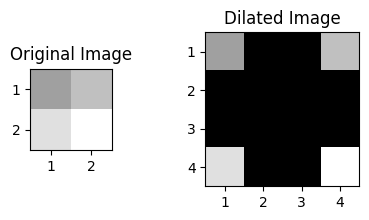

In [12]:
def dilate(tensor, stride):
    if stride == 1:
        return tensor

    batch_size, num_channels, height, width = tensor.shape
    
    dilated_height = height + (height - 1) * (stride - 1)
    dilated_width = width + (width - 1) * (stride - 1)
    
    dilated_tensor = np.zeros((batch_size, num_channels, dilated_height, dilated_width)).astype(tensor.dtype)
    dilated_tensor[:, :, ::stride, ::stride] = tensor
    return dilated_tensor

# Example usage of dilate function
example_image = np.arange(5, 9).reshape(1, 1, 2, 2)
dilated_image = dilate(example_image, 3)
print("Original Image Shape:", example_image.shape)
print("Dilated Image Shape:", dilated_image.shape)

fig, axs = plt.subplots(1, 2, figsize=(5, 2), gridspec_kw={'width_ratios': [0.3, 1]})
plt.subplot(1, 2, 1)
plt.imshow(example_image[0, 0], cmap='gray', vmin=0, vmax=8)
plt.xticks([0, 1], [1, 2])
plt.yticks([0, 1], [1, 2])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(dilated_image[0, 0], cmap='gray', vmin=0, vmax=8)
plt.xticks([0, 1, 2, 3], [1, 2, 3, 4])
plt.yticks([0, 1, 2, 3], [1, 2, 3, 4])
plt.title('Dilated Image')
plt.show()

### Benchmark network (debug and testing purpose)

In [13]:
import torch
import torch.nn.functional as F
from torch import nn

class TesterCNN(nn.Module):
    def __init__(self, kernels: torch.Tensor, biases: torch.Tensor = None, stride=1, padding=0):
        super().__init__()
        out_ch, in_ch, k_h, k_w = kernels.shape
        self.stride = stride
        self.padding = padding
        
        self.conv = nn.Conv2d(in_channels=in_ch,
                              out_channels=out_ch,
                              kernel_size=(k_h, k_w),
                              stride=stride,
                              padding=padding,
                              bias=(biases is not None))
        with torch.no_grad():
            self.conv.weight.copy_(kernels)
            if biases is not None:
                self.conv.bias.copy_(biases)

        self.conv.weight.requires_grad_(False)
        if biases is not None:
            self.conv.bias.requires_grad_(False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return F.relu(self.conv(x))

## Nested-Loops Approach

### Nested-Loops Approach: Convolutional Layer - Forward

`nested_loop_convolution` implements a 2D convolution followed by ReLU activation using explicit nested loops. This is computationally highly inefficient.

**Inputs:**
    *   `batch_of_images`: size `(N, C_in, H_in, W_in)`.
    *   `kernels`: size `(C_out, C_in, K_H, K_W)`.
    *   `biases`: Per-filter biases `(C_out,)`.

**Steps:**
1.  **Padding & Output Size:** Input `batch_of_images` is padded to better extract information from tha borders of the images. Output dimensions $(O_H, O_W)$ are calculated using the formula in the Padding section.
2.  **Convolution:** The convolution is computed explicitly, iterating over each element of the patches from the input tensor and multiplying them by the "sliding" kernels. For each output element $(n, f, y_{out}, x_{out})$:
    $$ \text{Output}(n, f, y_{out}, x_{out}) = \left( \sum_{c=0}^{C_{in}-1} \sum_{k_y=0}^{K_H-1} \sum_{k_x=0}^{K_W-1} \text{Img}_{pad}(n, c, y_{out}S + k_y, x_{out}S + k_x) \cdot \text{Ker}(f, c, k_y, k_x) \right) + \text{Bias}(f) $$
3.  **ReLU Activation:** If `applyReLU=True`: $\text{ActivatedOutput} = \max(0, \text{Output})$. A binary `mask` (1 where Output > 0, else 0) is also returned for backpropagation.

<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/refs/heads/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Convolution of a 7x7 image (blue) with a 3x3 kernel (dark blue), resulting in a 5x5 output (green). <br><i>(Source: Dumoulin & Visin, A guide to convolution arithmetic for deep learning)</i></figcaption>
</figure>

In [14]:
def nested_loop_convolution(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    if applyReLU: # Forward case
        output_channels, input_channels, kernel_width, kernel_height = kernels.shape
        kernel_channels = output_channels
    else: # Backward case
        input_channels, output_channels, kernel_width, kernel_height = kernels.shape
        kernel_channels = input_channels

    # biases has shape (output_channels, 1, 1). It's a scalar value for each channel broadcasted to the kernel's width and height
    # The number of channels taken in input by the kernel 'input_channels' must be the same as the number of channels of the image 'channels'

    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))
    batch_size, channels, image_height, image_width  = batch_of_images.shape
    output_image_height = int(((image_height - kernel_height) / stride) + 1) # new image height # Padding is already added
    output_image_width = int(((image_width - kernel_width) / stride) + 1) # new image width
    output = np.zeros((batch_size, output_channels, output_image_height, output_image_width)).astype(np.float32) # new image

    if input_channels != channels:
        raise ValueError(f"number of channels taken in input by the kernel ({input_channels}) must be the same as the number of channels of the image ({channels})")

    for single_image in range(batch_size):
        for single_kernel_channel in range(kernel_channels):
            for output_row_idx in range(output_image_height): # which cycles row by row of the new image
                for output_col_idx in range(output_image_width): # which cycles column by column of the new image
                    output_cell_accumulator = 0.0  # sum for the current output cell (accumulates the convolution result)
                    # Convolution cycles
                    for channel in range(input_channels): # channels == input_channels
                        for kernel_row_idx in range(kernel_height):
                            # Position of the kernel over the input image: row
                            input_row_idx = (output_row_idx * stride) + kernel_row_idx
                            for kernel_col_idx in range(kernel_width):
                                # Position of the kernel over the input image: column
                                input_col_idx = (output_col_idx * stride) + kernel_col_idx

                                # Check if the position is inside the image
                                if 0 <= input_row_idx < image_height and 0 <= input_col_idx < image_width:
                                    input_element = batch_of_images[single_image, channel, input_row_idx, input_col_idx]
                                    kernel_element = kernels[single_kernel_channel, channel, kernel_row_idx, kernel_col_idx]
                                    # Compute the convolution sum (to be done for each element of the sliding kernel over the image)
                                    output_cell_accumulator += (input_element * kernel_element).astype(np.float32)

                    # Assign the result to the output image
                    output[single_image, single_kernel_channel, output_row_idx, output_col_idx] = output_cell_accumulator

    if biases.all() != 0:
        biases = biases.reshape(biases.shape[0],1,1)

        if biases.shape[0] != output_channels:
            raise ValueError(f"biases dimension ({biases.shape[0]}) doesn't match kernel's number of channels ({output_channels})")
        
        output = output + biases

    output = output.astype(np.float32)

    if applyReLU:
        output = np.maximum(0, output)
        mask = output.copy()
        mask[mask > 0] = 1

        return output, mask
    else:
        return output

#-------------------------------------------- Examples --------------------------------------------------------
example_image = np.arange(1,3*3+1).reshape(1,1,3,3).astype(np.float32)
print("-------example_image--------")
print(example_image)

example_kernel = np.arange(1,8+1).reshape(2,1,2,2)
print("-------example_kernel-------")
print(example_kernel)

example_biases = np.array([1,2]).reshape(2,1,1)
outpout, mask = nested_loop_convolution(example_image, example_kernel, biases=example_biases, padding=1, stride=2)
print("-------Nested-Loop approach-------")
print(outpout)
# print("------mask-------")
# print(mask)

example_kernel = torch.from_numpy(example_kernel).float()
example_biases = torch.from_numpy(np.array([1,2])).float()
testerCNNmodel = TesterCNN(kernels=example_kernel,biases=example_biases, stride=2, padding=1)

x = torch.from_numpy(example_image)
y = testerCNNmodel(x)
print("-------PyTorch model-------")
print(y)

-------example_image--------
[[[[1. 2. 3.]
   [4. 5. 6.]
   [7. 8. 9.]]]]
-------example_kernel-------
[[[[1 2]
   [3 4]]]


 [[[5 6]
   [7 8]]]]
-------Nested-Loop approach-------
[[[[  5.  19.]
   [ 37.  78.]]

  [[ 10.  40.]
   [ 82. 191.]]]]
-------PyTorch model-------
tensor([[[[  5.,  19.],
          [ 37.,  78.]],

         [[ 10.,  40.],
          [ 82., 191.]]]])


### Nested-Loops Approach: Convolutional Layer - Backward

### Nested-Loops Approach: Convolutional Layer - Backward

We now need to implement the backward pass of a convolutional layer, calculating the gradients of the loss function with respect to the layer's weights (or kernels) ($W^{(i)}$), biases ($b^{(i)}$), and the layer's input (images) ($X^{(i)}$).

**Notation:**
*   $L$: The Loss function.
*   $X^{(i)}$: The input to convolutional layer $i$.
*   $W^{(i)}$: The weights (kernels) of layer $i$.
*   $b^{(i)}$: The biases of layer $i$.
*   $Z^{(i)}$: The pre-activation output of layer $i$ ($Z^{(i)} = \text{conv}(X^{(i)}, W^{(i)}) + b^{(i)}$).
*   $A^{(i)}$: The activated output of layer $i$ (e.g., $A^{(i)} = \text{ReLU}(Z^{(i)})$).
*   $\frac{\partial L}{\partial A^{(i)}}$: The gradient of the loss with respect to the activated output $A^{(i)}$ of the current layer (propagated from the next layer).
*   $\frac{\partial L}{\partial Z^{(i)}}$: The gradient of the loss with respect to the pre-activation output $Z^{(i)}$ of the current layer. This is often denoted as $\delta^{(i)}$ in your original text after passing through the ReLU derivative.
*   $\text{mask}^{(i)}$: The binary mask derived from the ReLU activation in the forward pass (1 if $Z^{(i)} > 0$, else 0).

**Steps:**

1.  **Gradient through ReLU Activation (Backward ReLU):**
    The derivative of ReLU is 1 for positive inputs and 0 otherwise. This is efficiently implemented by element-wise multiplying the incoming gradient $\frac{\partial L}{\partial A^{(i)}}$ with the `mask` computed during the forward pass.
    $$
    \frac{\partial L}{\partial Z^{(i)}} = \frac{\partial L}{\partial A^{(i)}} \odot \text{mask}^{(i)}
    $$
    where $\odot$ denotes the Hadamard (element-wise) product. Henceforth, for brevity, we will denote $\frac{\partial L}{\partial Z^{(i)}}$ as $\delta_Z^{(i)}$.

2.  **Gradient with respect to Weights ($W^{(i)}$):**
    To calculate $\frac{\partial L}{\partial W^{(i)}}$, we need to correlate the layer's input $X^{(i)}$ with the pre-activation output gradient $\delta_Z^{(i)}$. Each weight $W_{f,c,k_y,k_x}$ contributes to multiple elements of the output $Z^{(i)}$. Its gradient is the sum of all these contributions. Mathematically, this is equivalent to a convolution between the input $X^{(i)}$ (appropriately padded as in the forward pass) and the gradient $\delta_Z^{(i)}$ (which is treated as the "kernel" for this convolution).
    $$
    \frac{\partial L}{\partial W^{(i)}} = \text{Convolution}(X^{(i)}_{padded}, \delta_Z^{(i)})
    $$
    This convolution must always have a stride = 1.
* **Dilation of $\delta_Z^{(i)}$ (if forward stride > 1):** If the forward pass used a stride $S > 1$, $\delta_Z^{(i)}$ must be dilated by inserting $S-1$ zeros between its elements *before* this convolution for $\frac{\partial L}{\partial W^{(i)}}$. **This technique allows the use of a standard convolution**, where the "kernel" ($\delta_Z^{(i)}$) slides over the "image" ($X^{(i)}$), and makes the output's size equal to the one of the original kernel.
    
    (If $X^{(i)}$ is $(N, C_{in}, H_{in}, W_{in})$ and $\delta_Z^{(i)}$ is $(N, C_{out}, H_{out}, W_{out})$, the result $\frac{\partial L}{\partial W^{(i)}}$ will have shape $(C_{out}, C_{in}, K_H, K_W)$, as the original kernel.)

3.  **Gradient with respect to Input ($X^{(i)}$):**
    To propagate the gradient to the previous layer, we also need to calculate $\frac{\partial L}{\partial X^{(i)}}$. This operation is known as a "Full Convolution". It involves convolving the gradient $\delta_Z^{(i)}$ with the kernels $W^{(i)}$ rotated by 180 degrees (or flipped both horizontally and vertically) ($W^{(i)}_{rot180}$).
    $$
    \frac{\partial L}{\partial X^{(i)}} = \text{FullConvolution}(\delta_Z^{(i)}, W^{(i)}_{rot180})
    $$
    ***Note:*** *The name "Full Convolution" refers to the fact that the first term of the operation is padded as much as possible (a larger padding would make some patches contain only zeros, so it would not make sense).*
    
    Full Convolution is implemented as follows:
    *   **Dilation of $\delta_Z^{(i)}$:** As for the gradient w.r.t. the weights, if the stride $S$ of the forward pass was greater than 1, $\delta_Z^{(i)}$ is "dilated". Let's call this $\delta_{Z,dilated}^{(i)}$. If $S=1$, $\delta_{Z,dilated}^{(i)} = \delta_Z^{(i)}$.
    *   **Padding of $\delta_{Z,dilated}^{(i)}$:** The dilated gradient is padded. If $P_{fwd}$ was the forward pass padding and $K$ the kernel dimension, the padding here is $K-1-P_{fwd}$ on each side.
    *   **Convolution:** The padded $\delta_{Z,dilated}^{(i)}$ is convolved with $W^{(i)}_{rot180}$. The stride of this convolution is always 1.
    The result $\frac{\partial L}{\partial X^{(i)}}$ will have the same spatial dimensions as the original input $X^{(i)}$.

4.  **Gradient with respect to Biases ($b^{(i)}$):**
    Since the bias $b_c^{(i)}$ (corresponding to filter $c$) is added to all elements of channel $c$ of the pre-activation output $Z^{(i)}$, its gradient is simply the sum of all elements of $\delta_Z^{(i)}$ (the gradient *before* dilation) over that channel, across the spatial dimensions (height and width) and across all examples in the batch.
    $$
    \frac{\partial L}{\partial b^{(i)}_c} = \sum_{n} \sum_{h,w} (\delta_Z^{(i)})_{n,c,h,w}
    $$
---
<div style="text-align:center;">
<b>Visual example of forward and backward pass, with padding = 1 and striding = 2:</b>
<div style="display:flex; flex-direction:row; justify-content:space-between; align-items:flex-start; margin-top:15px;">
<figure style="text-align:center; width:50%; flex-grow:1; margin-top:0px;">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/refs/heads/master/gif/padding_strides.gif", style="border-radius:20px; height:200px;"/>
    <figcaption> The input image (blue) is 5x5, and the kernel (gray) is 3x3. The input has padding = 1 a stride = 2 is used. As we can see, the output is 3x3.</figcaption>
</figure>
<figure style="text-align:center; width:50%; flex-grow:1; margin-top:0px;">
    <img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_transposed.gif", style="border-radius:20px; height:200px;"/>
    <figcaption>Corresponding backward phase: the output gradient of the previous convolution is the 3x3 blue input. It is padded and dilated by stride-1=2-1=1 and convolved with the rotated kernel (gray) to produce the input gradient (5x5 green output).</figcaption>
</figure>
</div>
<figcaption style="text-align:center;"><i><a href"https://arxiv.org/pdf/1603.07285">(Source: A guide to convolution arithmetic for deep learning - Dumoulin & Visin)</a></i>
</fgcaption>
</div>

In [15]:
def nested_loop_gradient(batch_of_images, d_image, kernels, mask, padding=0, stride=1):
    """
    Performs the backward pass of the convolution layer. It takes the original image, 
    the gradient image, and then the kernel, padding and stride used in the convolution.
    The mask is needed to perform the ReLU operation.
    It returns the gradient w.r.t. the Original Image and the gradient of the kernel,
    to backpropagate the error.
    The gradient of the bias is also returned.
    """ 
    ############### Gradient of Input Image ###############
    # The computation consists in a convolution where the image is the gradient of the output image
    # dilated (zeros between matrix elements) by stride-1 and padded by kernel-1 in height and width.
    # The kernel is flipped by 180 degrees and the stride is set to 1.
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape
    batch_size, image_channels, image_height, iamge_width = batch_of_images.shape

    # Backward ReLU
    d_image = np.multiply(d_image, mask)

    # Dilate the gradient of the output
    d_image = dilate(d_image, stride)

    d_image = np.pad(d_image,
                     (
                      (0,0),(0,0),
                      (kernel_height-1-padding, kernel_height-1-padding),
                      (kernel_width-1-padding, kernel_width-1-padding)
                     ))
    
    batch_size, kernels_number, d_image_height, d_iamge_width = d_image.shape
    
    # Flip the kernel
    flipped_kernel = np.rot90(kernels,2,(-2,-1))

    # Computation
    gradient_wrt_image = np.zeros_like(batch_of_images)
    current_sum = 0.0
    for single_image in range(batch_size):
        for image_row_idx in range(image_height):
            for image_col_idx in range(iamge_width):
                for single_kernel in range(kernels_number):
                    for input_channel in range(kernel_channels):
                        for kernel_row_idx in range(kernel_height):
                            y = image_row_idx + kernel_row_idx

                            for kernel_col_idx in range(kernel_width):
                                x = image_row_idx + kernel_col_idx

                                if 0 <= y < d_image.shape[-2] and 0 <= x < d_image.shape[-1]:
                                    input_element = d_image[single_image,single_kernel,y,x]
                                    kernel_element = flipped_kernel[single_kernel,input_channel,kernel_row_idx,kernel_col_idx] 
                                else:
                                    break

                                current_sum += input_element*kernel_element

                    gradient_wrt_image[single_image,input_channel,image_row_idx,image_col_idx] = current_sum
                    current_sum = 0.0

    ############### Gradient of Kernel ###############
    # The computation consists in a convolution between the original image and the dilated gradient of the output image in order to
    # find the kernel
    gradient_wrt_kernel = np.zeros_like(kernels)
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))

    current_sum = 0.0

    for single_image in range(batch_size):
        for kernel_row_idx in range(kernel_height):
            for kernel_col_idx in range(kernel_width):
                for input_channel in range(kernel_channels):
                    # The number of kernels determines the number of channels of the output tensor
                    for outpot_channel in range(kernels_number):
                        for d_image_row_idx in range(d_image_height):
                            y = kernel_row_idx + d_image_row_idx

                            for d_image_col_idx in range(d_iamge_width):
                                x = kernel_row_idx + d_image_col_idx

                                if 0 <= y < image_height and 0 <= x < iamge_width:
                                    input_element = batch_of_images[single_image,input_channel,y,x]
                                    kernel_element = d_image[single_image,outpot_channel,d_image_row_idx,d_image_col_idx] 
                                    current_sum += input_element*kernel_element
                                else:
                                    break

                        gradient_wrt_kernel[outpot_channel,input_channel,kernel_row_idx,kernel_col_idx] = current_sum
                        current_sum = 0.0

    ############### Gradient of Bias ###############
    # The computation consists in summing the gradient of the output image together to find the bias for every channel
    gradient_wrt_bias = d_image.sum((-1,-2)) # sum over height and width
    
    return gradient_wrt_image, gradient_wrt_kernel, gradient_wrt_bias

kernel_channels = 1
kernels_number = 2
image_side_len = 7
kernel_side_len = 2
example_stride = 2
example_padding = 1

example_image = np.arange(1, kernel_channels * image_side_len * image_side_len + 1)
example_image = example_image.reshape(1, kernel_channels, image_side_len, image_side_len)

example_kernel = np.arange(1, kernels_number * kernel_channels * (kernel_side_len**2) + 1)
example_kernel = example_kernel.reshape(kernels_number, kernel_channels, kernel_side_len, kernel_side_len)

example_d_image, mask = nested_loop_convolution(example_image, example_kernel, stride=example_stride, padding=example_padding) 
example_d_image = example_d_image / np.mean(example_d_image)

image_grad, kernel_grad, bias_grad = nested_loop_gradient(example_image, example_d_image, example_kernel, mask, stride=example_stride, padding=example_padding)

print(f"image: {example_image.shape}")
print(f"kernel: {example_kernel.shape}")
print(f"d_image: {example_d_image.shape}")
print(f"gradient w.r.t. image: {image_grad.shape}")
print(f"gradient w.r.t. kernel: {kernel_grad.shape}")

image: (1, 1, 7, 7)
kernel: (2, 1, 2, 2)
d_image: (1, 2, 4, 4)
gradient w.r.t. image: (1, 1, 7, 7)
gradient w.r.t. kernel: (2, 1, 2, 2)


## Im2Col Approach

### Im2Col approach: Convolutional Layer - Forward

`im2col_convolution` implements 2D convolution more efficiently using an Im2Col approach using`sliding_window_view` and optimized matrix multiplication.

**Im2Col Core Idea:**

* **Input Patch Extraction:**
    *   `window_m = ... .reshape((-1,(kw*kh*nc)))`: Flattens each extracted patch into a row vector of size `kw*kh*nc`. `window_m` (our $X_{col}$) thus has shape `(N_patches, patch_size)`.
    *   `kernel = kernel.reshape((-1,(kw*kh*nc))).transpose(1,0)`: Flattens each filter `(kc, ac, kw, kh)` -> `(kc, ac*kw*kh)`. This is $W_{col}$, shape `(patch_size, C_out)`.
    Following the example in the animation below, we have a 4x4 RGB image (so **3x4x4**) that has to be convoluted by a **2x2** kernel (represented as the red outlines sliding over the image). The kernel will slide **9** times over the image and, for each slide, the number of multiplications and values to be summed is 4 (elements of the kernel) times 3 (channels of both the image and the kernel) that equals **12**. Hence, as we can see in the animation below, the flattened patches are vectors of **12** elements, and in total they are **9**, as the slides performed by the kernel.
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/1.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Each patch is extracted and flattened into a vector</figcaption>
</figure>

* **Kernel Reshaping**:
    To perform the convolution as a vetor-matrix multilication (or matrix-matrix multiplication) we then have to flatten the kernel(s) into row vectors
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/10.png" height="250", style="border-radius:20px;"/>
    <figcaption>Kernels are flattened into a vector</figcaption>
</figure>

* **Convolution as Matrix Multiplication:**
    At this point, the convolution boils down to a simple matrix multiplication, with enormous gains in efficiency and simplicity
<figure style="text-align:center;">
    <img src="https://raw.githubusercontent.com/valoxe/image-storage-1/master/blog-deep-learning/cnnumpy-fast/11.gif" height="250", style="border-radius:20px;"/>
    <figcaption>Each element of the output is given by a simple and optimized dot product</figcaption>
</figure>

In [16]:
def im2col_convolution(batch_of_images, kernels, biases=np.array(0), padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape

    ###### im2col approach steps: ######
    # 1. Pad the input image as needed
    if padding > 0:
        batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))

    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    # 2. Extract sliding windows from the input image, considering the kernel size and stride
    sliding_windows = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,input_channels,kernel_height,kernel_width))[:,:,::stride,::stride]

    # 3. Flatten the sliding windows and the kernel to prepare for matrix multiplication
    sliding_windows = sliding_windows.reshape((-1,(kernel_height * kernel_width * input_channels)))

    kernels = kernels.reshape((-1,(kernel_height*kernel_width*input_channels))).transpose(1,0)

    # Now, the convolution can be performed as a matrix multiplication, where each row of the sliding windows
    # corresponds to a flattened patch of the input image, and each column of the kernels corresponds to a flattened kernel (channel-wise)
    images_dot_kernels = np.matmul(sliding_windows, kernels).astype(np.float32) # It's called 'images_dot_kernels' because it contains the result of the whole convolution operation

    # Compute the output dimensions to reshape the resulting matrix (each row corresponds to a patch)
    output_width = int(((image_width - kernel_width) / stride) + 1)
    output_height = int(((image_height - kernel_height) / stride) + 1)

    # First operate a reshape keeping spatial ordering, which has channels at the end
    output = images_dot_kernels.reshape(batch_size, output_width, output_height, kernels_number)

    # Transpose to have input in shapes (batch, output_channel, height, width)
    output = output.transpose(0,3,1,2).astype(np.float32)

    # Add biases if they are provided
    if biases.any() != 0:
        output = (output + biases.reshape(1,-1,1,1))

    # Apply ReLU activation if specified
    if applyReLU:
        output = np.maximum(0, output)

    # Create a mask for the backward operation of ReLU activation
    mask = np.copy(output)
    mask[mask > 0] = 1

    return output, mask

img = np.arange(1,4*5*5+1).reshape(1,4,5,5).astype(np.float32)
print("-------img-------")
print(img)
ker = np.arange(1,32+1).reshape(2,4,2,2)
print("-------ker-------")
print(ker)
bias = np.array([1,2]).reshape(2,1,1)

s = 4

res,mask = nested_loop_convolution(img, ker, bias,padding=0,stride=s)
print("-------Conv Slow-------")
print(res)
X_c,mask = im2col_convolution(img, ker, bias,padding=0,stride=s)
print("-------Conv Fast-------")
print(X_c)

-------img-------
[[[[  1.   2.   3.   4.   5.]
   [  6.   7.   8.   9.  10.]
   [ 11.  12.  13.  14.  15.]
   [ 16.  17.  18.  19.  20.]
   [ 21.  22.  23.  24.  25.]]

  [[ 26.  27.  28.  29.  30.]
   [ 31.  32.  33.  34.  35.]
   [ 36.  37.  38.  39.  40.]
   [ 41.  42.  43.  44.  45.]
   [ 46.  47.  48.  49.  50.]]

  [[ 51.  52.  53.  54.  55.]
   [ 56.  57.  58.  59.  60.]
   [ 61.  62.  63.  64.  65.]
   [ 66.  67.  68.  69.  70.]
   [ 71.  72.  73.  74.  75.]]

  [[ 76.  77.  78.  79.  80.]
   [ 81.  82.  83.  84.  85.]
   [ 86.  87.  88.  89.  90.]
   [ 91.  92.  93.  94.  95.]
   [ 96.  97.  98.  99. 100.]]]]
-------ker-------
[[[[ 1  2]
   [ 3  4]]

  [[ 5  6]
   [ 7  8]]

  [[ 9 10]
   [11 12]]

  [[13 14]
   [15 16]]]


 [[[17 18]
   [19 20]]

  [[21 22]
   [23 24]]

  [[25 26]
   [27 28]]

  [[29 30]
   [31 32]]]]
-------Conv Slow-------
[[[[ 7689.]]

  [[18314.]]]]
-------Conv Fast-------
[[[[ 7689.]]

  [[18314.]]]]


### Im2Col approach: Convolutional Layer - Backward

`im2col_gradient` computes the following gradients using again the im2col approach:
* $\frac{\partial L}{\partial X}$ (`gi`): gradient w.r.t. the input images;

* $\frac{\partial L}{\partial W}$ (`gk`): gradient w.r.t. the kernels;

* $\frac{\partial L}{\partial b}$ (`gb`): gradient w.r.t. the biases.

**Steps:**

1.  **Backward ReLU:** $\frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \odot \text{mask}$<br>
    "$\text{mask}$" is a matrix (tensor) whose elements are 1 if the corrisponding elements in the output of a given layer were > 0. It enables the flowing of the gradient only through elements that contributed to form the output in the first place.

2.  **Gradient w.r.t. Input (`gi`):**
    $\frac{\partial L}{\partial X} = \text{FullConv}(\left(\frac{\partial L}{\partial Z}\right)_{dilated}, W_{rot180})$<br>
    A full convolution is needed, since we must obtain a result with the same size as the input image. As you remember, the output size is given by this formula: $O = \lfloor \frac{(I - K + 2P)}{S} \rfloor + 1$, so we must "invert" it. In particular, the output tensor must be:
    * dilated by $stride - 1$ and
    * padded by:
    $(kernel\_height-1-input\_padding{\textnormal{, }}kernel\_width-1-input\_padding)$

2.  **Gradient w.r.t. Kernel (`gk`):**
    This is $\frac{\partial L}{\partial W} = \text{Conv}(X_{padded}, \frac{\partial L}{\partial Z})$.
   

3.  **Gradient w.r.t. Bias (`gb`):** $\frac{\partial L}{\partial b_f} = \sum_{n,h,w} (\frac{\partial L}{\partial Z})_{n,f,h,w}$. (`gb = d_img.sum((-1,-2))`).

**But what if, in the forward phase, the stride was greater than 1?**<br>
Dilation was already mentioned, but here we will give you again an explanation, but with a detailed visual example. Consider the case in which the stride was $S= 2$ in the forward pass. The output gradient tensor needs to be dilated (in order to obtain a tensor with the same size as the input image) before being convolved with the kernel gradient, to be effectively useful to backpropagate the loss. A visualization of why dilation enables this fundamental result is in the gif below:
<figure style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*KOHfsOHX5ujcMfr6Xjy6zQ.png" height="250", style="border-radius:20px 0 0 20px;"/>
    <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*QvTW-pNwJAlbfj1LrZe8JA.gif" height="250", style="border-radius:0 20px 20px 0;"/>
    <figcaption>The backpropagation operation is identical to a stride = 1 convolution of a padded, dilated version of the output gradient tensor with a flipped version of the filter.<br><i><a href="https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710">(Source: Backpropagation for Convolution with Strides, Mayank Kaushik)</a></i></figcaption>
</figure>

In [17]:
def im2col_gradient(batch_of_images, d_image, kernels, mask, padding=0, stride=1):
    """
    NEW APPROACH !
    Performs the backward pass of the convolution layer. It takes the original image, 
    the gradient image, and then the kernel, padding and stride used in the convolution. Also the mask is needed to perform the ReLU operation.
    It returns the gradient w.r.t. the Original Image to back propagate and the gradient of the kernel
    """
    ############ Gradient of Input Image ############
    # The computation consists in a convolution where the image is the gradient of the output image dilated (zeros between matrix elements) of stride-1
    # and padded of kernel-1 dimensions 
    # and the kernel is rotated by 180 degrees (flipped vertically and horizontally)
    # FullConvolution(d_imageDilated, Rotated180Deg(kernel)) with stride 1
    output_channels, input_channels, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    # backward ReLU
    d_image = np.multiply(d_image, mask)

    # Delating the gradient of the output
    d_image = dilate(d_image, stride)
  
    # Padding the gradient of the output
    d_image_padded = np.pad(d_image,((0,0),(0,0),(kernel_height-1-padding,kernel_height-1-padding),(kernel_width-1-padding,kernel_width-1-padding)))

    batch_size, output_channels, d_image_height, d_image_width = d_image.shape
    
    # flipping the kernel
    kernels = np.rot90(kernels,2,(-2,-1))

    sliding_windows_d_image = np.lib.stride_tricks.sliding_window_view(d_image_padded,(1,output_channels,kernel_width,kernel_height))
    sliding_windows_d_image = sliding_windows_d_image.reshape(-1,(kernel_width*kernel_height*output_channels)) # window matrix
    
    # Convolution
    kernels = kernels.reshape((-1,(kernel_width*kernel_height*output_channels))).transpose(1,0)

    gradient_wrt_images = np.matmul(sliding_windows_d_image, kernels).astype(np.float32).transpose(1,0).reshape(batch_of_images.shape)
    
    ############## Gradient of Kernel ##############
    # The computation consists in a convolution between the original image and the dilated gradient of the output image in order to
    # find the kernel
    batch_of_images = np.pad(batch_of_images,((0,0),(0,0),(padding,padding),(padding,padding)))

    sliding_windows_batch_of_images = np.lib.stride_tricks.sliding_window_view(batch_of_images,(1,1,d_image_height,d_image_width)).reshape(-1,d_image_height*d_image_width)
    
    d_image = d_image.reshape(-1, d_image_height * d_image_width).transpose(1,0)
    
    gradient_wrt_kernels = np.matmul(sliding_windows_batch_of_images, d_image).astype(np.float32).transpose(1,0).reshape(output_channels,input_channels,kernel_height,kernel_width)
    
    ############### Gradient of Bias ###############
    # The computation consists in summing the gradient of the output image together to find the bias for every channel
    grdient_wrt_biases = d_image.sum((-1,-2)) # sum over height and width
    
    ################################################### Return Results ###############################################
    return gradient_wrt_images, gradient_wrt_kernels, grdient_wrt_biases

input_channels = 3
output_channels = 4
idim = 9
kdim = 3
s = 3
p = 0

imAge = np.arange(1,input_channels*idim*idim+1).reshape(1,input_channels,idim,idim)
kerNel = np.arange(1,output_channels*input_channels*(kdim**2)+1).reshape(output_channels,input_channels,kdim,kdim)
dimAge,mask = im2col_convolution(imAge,kerNel,stride=s,padding=p) 
dimAge = dimAge/np.mean(dimAge)
print(f"dimAge: {dimAge.shape}")

ggi,ggradient_wrt_kernels,ggrdient_wrt_biases = im2col_gradient(imAge,dimAge,kerNel,mask,stride=s,padding=p)
print(f"imAge: {imAge.shape}")
print(f"kerNel: {kerNel.shape}")
print(f"dimAge: {dimAge.shape}")
print(f"ggi: {ggi.shape}")
print(f"ggradient_wrt_kernels: {ggradient_wrt_kernels.shape}")

dimAge: (1, 4, 3, 3)
imAge: (1, 3, 9, 9)
kerNel: (4, 3, 3, 3)
dimAge: (1, 4, 3, 3)
ggi: (1, 3, 9, 9)
ggradient_wrt_kernels: (4, 3, 3, 3)


### Optimized version

Reading the extremely interesting article [Faster Matrix Multiplications in Numpy](https://www.benjaminjohnston.com.au/matmul) by Benjamin Johnson, we extracted fundamental tips and techniques that allowed us to significantly improve the performances of our im2col approach. Following the order of the steps in the article, we now will briefly present them and apply them to our code.

1. **Use BLAS directly, instead of relying on BLAS-based operations of NumPy:** *"BLAS is a high-performance matrix library. Even though NumPy uses BLAS, I've noticed performance can be improved by calling BLAS directly. Perhaps this is simply because using direct calls to BLAS forces you to shape your data ready for use with BLAS.<br>Replace numpy.matmul with `scipy.linalg.blas.sgemm(...)` for float32 matrix-matrix multiplication and `scipy.linalg.blas.sgemv(...)` for float32 matrix-vector multiplication."*
2. **Use the fastest BLAS possible**

* Specifi-transposition (to optimize BLAS operations):

In [54]:
def im2col_optimized(batch_of_images, kernels, biases=None, padding=0, stride=1, applyReLU=True):
    # Ensure all inputs are float64
    batch_of_images = batch_of_images.astype(np.float64, copy=False)
    kernels = kernels.astype(np.float64, copy=False)
    if biases is not None:
        biases = biases.astype(np.float64, copy=False)

    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    if kernel_channels != input_channels:
        raise ValueError(f"Numero di canali del kernel ({kernel_channels}) non corrisponde ai canali dell'input ({input_channels})")

    output_height = (image_height - kernel_height + 2 * padding) // stride + 1
    output_width = (image_width - kernel_width + 2 * padding) // stride + 1

    if padding > 0:
        batch_of_images_padded = np.pad(batch_of_images, ((0, 0), (0, 0), (padding, padding), (padding, padding)), mode='constant')
    else:
        batch_of_images_padded = batch_of_images

    patches = np.lib.stride_tricks.sliding_window_view(
        batch_of_images_padded,
        (1, input_channels, kernel_height, kernel_width)
    )
    patches_strided = patches[:, :, ::stride, ::stride, :, :, :, :]

    X_col = patches_strided.transpose(0, 2, 3, 5, 6, 7, 1, 4).reshape(
        batch_size * output_height * output_width,
        input_channels * kernel_height * kernel_width
    ).astype(np.float64, copy=False)

    W_col = kernels.reshape(kernels_number, -1).T.astype(np.float64, copy=False)

    output_col = np.matmul(X_col, W_col).astype(np.float64, copy=False)

    output = output_col.reshape(batch_size, output_height, output_width, kernels_number)
    output = output.transpose(0, 3, 1, 2)

    if biases is not None and biases.any() != 0:
        output = output + biases.reshape(1, -1, 1, 1)

    mask = None

    if applyReLU:
        output_activated = np.maximum(0, output)
        mask = (output_activated > 0).astype(np.float64)
        output = output_activated
    else:
        mask = np.ones_like(output, dtype=np.float64)

    return output.astype(np.float64, copy=False), mask.astype(np.float64, copy=False)

def im2col_gradient_optimized(
    original_forward_input,
    d_image,
    kernels,
    mask,
    padding,
    stride
    ):
    # Ensure all inputs are float64
    original_forward_input = original_forward_input.astype(np.float64, copy=False)
    d_image = d_image.astype(np.float64, copy=False)
    kernels = kernels.astype(np.float64, copy=False)
    mask = mask.astype(np.float64, copy=False)

    gradient_pre_activation = np.multiply(d_image, mask).astype(np.float64, copy=False)

    kernels_number, input_channels_kernel, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels_orig, input_height, input_width = original_forward_input.shape

    gradient_wrt_biases = np.sum(gradient_pre_activation, axis=(0, 2, 3)).astype(np.float64, copy=False)

    if padding > 0:
        X_padded_for_dW = np.pad(original_forward_input, ((0,0), (0,0), (padding,padding), (padding,padding)), mode='constant')
    else:
        X_padded_for_dW = original_forward_input

    patches_X_for_dW = np.lib.stride_tricks.sliding_window_view(
        X_padded_for_dW,
        (1, input_channels_orig, kernel_height, kernel_width)
    )[:, :, ::stride, ::stride, :, :, :, :]

    X_col_for_dW = patches_X_for_dW.transpose(0, 2, 3, 5, 6, 7, 1, 4).reshape(
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        input_channels_orig * kernel_height * kernel_width
    ).astype(np.float64, copy=False)

    dLdZ_col = gradient_pre_activation.transpose(0, 2, 3, 1).reshape(
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        kernels_number
    ).astype(np.float64, copy=False)

    gradient_wrt_kernels_flat = np.matmul(X_col_for_dW.T, dLdZ_col).astype(np.float64, copy=False)

    gradient_wrt_kernels = gradient_wrt_kernels_flat.reshape(
        input_channels_orig, kernel_height, kernel_width, kernels_number
    ).transpose(3, 0, 1, 2).astype(np.float64, copy=False)

    dilated_grad_pre_activation = dilate(gradient_pre_activation, stride).astype(np.float64, copy=False)

    flipped_kernels_for_dX = kernels[:,:,::-1,::-1].transpose(1,0,2,3).astype(np.float64, copy=False)

    padding_for_dX_conv = kernel_height - 1 - padding

    gradient_wrt_input_raw, _ = im2col_optimized(
        dilated_grad_pre_activation,
        flipped_kernels_for_dX,
        biases=None,
        padding=padding_for_dX_conv,
        stride=1,
        applyReLU=False
    )

    gradient_wrt_input = gradient_wrt_input_raw[:, :, :input_height, :input_width].astype(np.float64, copy=False)

    return gradient_wrt_input, gradient_wrt_kernels, gradient_wrt_biases


* Direct call to underlying BLAS functions, without NumPy intermediation (works best if the tensors are really large):

In [19]:
from scipy.linalg.blas import sgemm

def im2col_optimized_sgemm(batch_of_images, kernels, biases=None, padding=0, stride=1, applyReLU=True):
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels, image_height, image_width = batch_of_images.shape
    if kernel_channels != input_channels:
        raise ValueError(f"Numero di canali del kernel ({kernel_channels}) non corrisponde ai canali dell'input ({input_channels})")
    output_height = (image_height - kernel_height + 2 * padding) // stride + 1
    output_width = (image_width - kernel_width + 2 * padding) // stride + 1
    
    current_dtype = batch_of_images.dtype # Per mantenere la precisione originale finché possibile
    if current_dtype != np.float32: # sgemm richiede float32
        current_dtype = np.float32

    if padding > 0:
        batch_of_images_padded = np.pad(batch_of_images.astype(current_dtype, copy=False),
                                        ((0, 0), (0, 0), (padding, padding), (padding, padding)),
                                        mode='constant')
    else:
        batch_of_images_padded = batch_of_images.astype(current_dtype, copy=False)

    patches = np.lib.stride_tricks.sliding_window_view(
        batch_of_images_padded,
        (1, input_channels, kernel_height, kernel_width)
    )
    patches_strided = patches[:, :, ::stride, ::stride, :, :, :, :]

    X_col_shape = (batch_size * output_height * output_width, input_channels * kernel_height * kernel_width)
    X_col_transposed_view = patches_strided.transpose(0, 2, 3, 5, 6, 7, 1, 4)
    # Assicura C-contiguità per la matrice 'a' di sgemm
    X_col = np.ascontiguousarray(X_col_transposed_view.reshape(X_col_shape), dtype=np.float32)

    # Prepara i kernel per sgemm con trans_b=True
    # kernels_reshaped avrà forma (OC, patch_size) ed è C-contigua
    kernels_reshaped_for_sgemm = np.ascontiguousarray(kernels.reshape(kernels_number, -1), dtype=np.float32)

    # sgemm calcola alpha * A @ B oppure A.T @ B ecc.
    # Vogliamo X_col @ W_col, dove W_col = kernels.reshape(OC, -1).T
    # Quindi, W_col ha forma (patch_size, OC).
    # Passando kernels_reshaped_for_sgemm (OC, patch_size) e trans_b=True,
    # sgemm calcolerà X_col @ kernels_reshaped_for_sgemm.T
    output_col = sgemm(alpha=1.0, a=X_col, b=kernels_reshaped_for_sgemm, trans_b=True)

    output = output_col.reshape(batch_size, output_height, output_width, kernels_number).transpose(0, 3, 1, 2)

    if biases is not None and biases.any() != 0:
        output = output + biases.astype(np.float32, copy=False).reshape(1, -1, 1, 1)

    mask_type = output.dtype
    if applyReLU:
        # np.maximum può cambiare il dtype se uno degli argomenti è 0 (int). Forziamo float32.
        output = np.maximum(0, output, dtype=np.float32)
        mask = (output > 0).astype(mask_type) # Maschera binaria con il dtype originale (prima di forzare float32)
    else:
        mask = np.ones_like(output, dtype=mask_type)

    return output.astype(np.float32, copy=False), mask.astype(np.float32, copy=False)

def im2col_gradient_optimized_sgemm(original_forward_input, d_image, kernels, mask, padding, stride):
    # Assicura che mask sia float32 se usata in moltiplicazioni
    gradient_pre_activation = np.multiply(d_image, mask.astype(d_image.dtype, copy=False)) # dL/dZ

    kernels_number, input_channels_kernel, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels_orig, input_height, input_width = original_forward_input.shape

    gradient_wrt_biases = np.sum(gradient_pre_activation, axis=(0, 2, 3)).astype(np.float32, copy=False)

    current_dtype = original_forward_input.dtype
    if current_dtype != np.float32:
        current_dtype = np.float32

    if padding > 0:
        X_padded_for_dW = np.pad(original_forward_input.astype(current_dtype, copy=False),
                                 ((0,0), (0,0), (padding,padding), (padding,padding)),
                                 mode='constant')
    else:
        X_padded_for_dW = original_forward_input.astype(current_dtype, copy=False)

    patches_X_for_dW = np.lib.stride_tricks.sliding_window_view(
        X_padded_for_dW,
        (1, input_channels_orig, kernel_height, kernel_width)
    )[:, :, ::stride, ::stride, :, :, :, :]

    X_col_for_dW_shape = (
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        input_channels_orig * kernel_height * kernel_width
    )
    X_col_for_dW_transposed_view = patches_X_for_dW.transpose(0, 2, 3, 5, 6, 7, 1, 4)
    # Assicura C-contiguità per 'a' in sgemm(trans_a=True)
    X_col_for_dW = np.ascontiguousarray(X_col_for_dW_transposed_view.reshape(X_col_for_dW_shape), dtype=np.float32)

    dLdZ_col_shape = (
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        kernels_number
    )
    dLdZ_col_transposed_view = gradient_pre_activation.transpose(0, 2, 3, 1)
    # Assicura C-contiguità per 'b' in sgemm(trans_a=True)
    # (anche se F-contiguità sarebbe ideale per 'b' se 'a' non è trasposta,
    # BLAS gestisce C-contigue per entrambe con trans_a=True)
    dLdZ_col = np.ascontiguousarray(dLdZ_col_transposed_view.reshape(dLdZ_col_shape), dtype=np.float32)

    # Calcola X_col_for_dW.T @ dLdZ_col
    gradient_wrt_kernels_flat = sgemm(alpha=1.0, a=X_col_for_dW, b=dLdZ_col, trans_a=True)

    gradient_wrt_kernels = gradient_wrt_kernels_flat.reshape(
        input_channels_orig, kernel_height, kernel_width, kernels_number
    ).transpose(3, 0, 1, 2).astype(np.float32, copy=False)

    # --- Calcolo di gradient_wrt_input (dL/dX) ---
    dilated_grad_pre_activation = dilate(gradient_pre_activation.astype(np.float32, copy=False), stride)

    # Ottimizzazione per rotazione kernel: W_rot180 = W[:, :, ::-1, ::-1] (flip per KH, KW)
    # Poi transpose per scambiare canali input/output per la convoluzione trasposta: (IC, OC, KH, KW)
    flipped_kernels_for_dX = kernels.astype(np.float32, copy=False)[:,:,::-1,::-1].transpose(1,0,2,3)
    # Assicura che i kernel flippati siano C-contigui per la chiamata ricorsiva a im2col_optimized_v3
    flipped_kernels_for_dX = np.ascontiguousarray(flipped_kernels_for_dX)


    padding_for_dX_conv = kernel_height - 1 - padding

    gradient_wrt_input_raw, _ = im2col_optimized_sgemm(
        dilated_grad_pre_activation,
        flipped_kernels_for_dX,
        biases=None,
        padding=padding_for_dX_conv,
        stride=1,
        applyReLU=False
    )

    # Crop per ottenere le dimensioni corrette
    gradient_wrt_input = gradient_wrt_input_raw[:, :, :input_height, :input_width].astype(np.float32, copy=False)

    return gradient_wrt_input, gradient_wrt_kernels, gradient_wrt_biases

In [20]:
from im2col_cython import im2col_optimized_cython, im2col_gradient_optimized_cython

### Optimized version w/o bias

In [21]:
def im2col_optimized_float64_no_bias(batch_of_images, kernels, biases=None, padding=0, stride=1, applyReLU=True):
    # Questa è la tua funzione im2col_optimized, ma forziamo float64 internamente
    kernels_number, kernel_channels, kernel_height, kernel_width = kernels.shape
    batch_size, input_channels, image_height, image_width = batch_of_images.shape

    if kernel_channels != input_channels:
        raise ValueError("Channel mismatch")

    output_height = (image_height - kernel_height + 2 * padding) // stride + 1
    output_width = (image_width - kernel_width + 2 * padding) // stride + 1

    # Assicura float64 dall'inizio
    current_dtype = np.float64
    batch_of_images_casted = batch_of_images.astype(current_dtype, copy=False)
    kernels_casted = kernels.astype(current_dtype, copy=False)
    biases_casted = biases.astype(current_dtype, copy=False) if biases is not None else None

    if padding > 0:
        batch_of_images_padded = np.pad(batch_of_images_casted, 
                                        ((0, 0), (0, 0), (padding, padding), (padding, padding)), 
                                        mode='constant')
    else:
        batch_of_images_padded = batch_of_images_casted

    patches = np.lib.stride_tricks.sliding_window_view(
        batch_of_images_padded,
        (1, input_channels, kernel_height, kernel_width)
    )
    patches_strided = patches[:, :, ::stride, ::stride, :, :, :, :]

    X_col = patches_strided.transpose(0, 2, 3, 5, 6, 7, 1, 4).reshape(
        batch_size * output_height * output_width,
        input_channels * kernel_height * kernel_width
    ).astype(current_dtype, copy=False) # Assicura che X_col sia float64

    W_col = kernels_casted.reshape(kernels_number, -1).T.astype(current_dtype, copy=False) # E W_col
    
    output_col = np.matmul(X_col, W_col) # Matmul manterrà float64 se gli input lo sono

    output = output_col.reshape(batch_size, output_height, output_width, kernels_number).transpose(0, 3, 1, 2)

    if biases_casted is not None and biases_casted.any() != 0:
        output = output + biases_casted.reshape(1, -1, 1, 1)

    mask_type = output.dtype # Sarà float64
    if applyReLU:
        output_activated = np.maximum(0, output) # Mantiene float64
        mask = (output_activated > 0).astype(mask_type)
        output = output_activated
    else:
        mask = np.ones_like(output, dtype=mask_type)
        
    return output, mask # output e mask saranno float64


def im2col_gradient_optimized_float64_no_bias(original_forward_input, d_image, kernels, mask, padding, stride):
    # Questa è la tua im2col_gradient_optimized, ma forza float64
    current_dtype = np.float64

    # Assicura che tutti gli input rilevanti siano float64
    original_forward_input_f64 = original_forward_input.astype(current_dtype, copy=False)
    d_image_f64 = d_image.astype(current_dtype, copy=False)
    kernels_f64 = kernels.astype(current_dtype, copy=False)
    mask_f64 = mask.astype(current_dtype, copy=False) # La maschera ora sarà 0.0 o 1.0

    gradient_pre_activation = np.multiply(d_image_f64, mask_f64).astype(current_dtype, copy=False)

    kernels_number, input_channels_kernel, kernel_height, kernel_width = kernels_f64.shape
    batch_size, input_channels_orig, input_height, input_width = original_forward_input_f64.shape

    # gradient_wrt_biases = np.sum(gradient_pre_activation, axis=(0, 2, 3)).astype(current_dtype, copy=False)

    X_padded_for_dW = original_forward_input_f64
    if padding > 0:
        X_padded_for_dW = np.pad(original_forward_input_f64, 
                                 ((0,0), (0,0), (padding,padding), (padding,padding)), 
                                 mode='constant')

    patches_X_for_dW = np.lib.stride_tricks.sliding_window_view(
        X_padded_for_dW,
        (1, input_channels_orig, kernel_height, kernel_width)
    )[:, :, ::stride, ::stride, :, :, :, :]

    X_col_for_dW = patches_X_for_dW.transpose(0, 2, 3, 5, 6, 7, 1, 4).reshape(
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        input_channels_orig * kernel_height * kernel_width
    ).astype(current_dtype, copy=False)

    dLdZ_col = gradient_pre_activation.transpose(0, 2, 3, 1).reshape(
        batch_size * gradient_pre_activation.shape[2] * gradient_pre_activation.shape[3],
        kernels_number
    ).astype(current_dtype, copy=False)
    
    gradient_wrt_kernels_flat = np.matmul(X_col_for_dW.T, dLdZ_col)
    gradient_wrt_kernels = gradient_wrt_kernels_flat.reshape(
        input_channels_orig, kernel_height, kernel_width, kernels_number
    ).transpose(3, 0, 1, 2).astype(current_dtype, copy=False)

    dilated_grad_pre_activation = dilate(gradient_pre_activation, stride) # dilate mantiene dtype
    
    flipped_kernels_for_dX = np.rot90(kernels_f64, 2, axes=(2, 3)).transpose(1, 0, 2, 3)
    flipped_kernels_for_dX = flipped_kernels_for_dX.astype(current_dtype, copy=False)

    padding_for_dX_conv = kernel_height - 1 - padding
    
    gradient_wrt_input_raw, _ = im2col_optimized_float64_no_bias( # Usa la versione float64
        dilated_grad_pre_activation, 
        flipped_kernels_for_dX,      
        biases=None,
        padding=padding_for_dX_conv, 
        stride=1, 
        applyReLU=False
    )
    gradient_wrt_input = gradient_wrt_input_raw[:, :, :input_height, :input_width].astype(current_dtype, copy=False)
    
    return gradient_wrt_input, gradient_wrt_kernels #, gradient_wrt_biases

## MLP Layer

### MLP Layer: Forward

`ReLU_SoftMax_FullyConnected` executes the forward pass of a two-layer Multi-Layer Perceptron (one hidden layer, one output layer), typically used for classification after feature extraction by convolutional layers.

In [22]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))  # for numerical stability
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def ReLU_SoftMax_FullyConnected(input_array, w1, b1, w2, b2):
    first_layer_output = np.matmul(input_array, w1) + b1
    first_layer_activation = np.maximum(0, first_layer_output)
    second_layer_output = np.matmul(first_layer_activation, w2) + b2
    second_layer_activation = softmax(second_layer_output)
    
    return first_layer_output, first_layer_activation, second_layer_output, second_layer_activation

def ReLU_SoftMax_FC_no_bias(input_array, w1, w2):
    first_layer_output = np.matmul(input_array, w1)
    first_layer_activation = np.maximum(0, first_layer_output)
    second_layer_output = np.matmul(first_layer_activation, w2)
    second_layer_activation = softmax(second_layer_output)
    
    return first_layer_output, first_layer_activation, second_layer_output, second_layer_activation


### MLP Layer: Backward

`ReLU_SoftMax_FC_Backward` computes gradients for the MLP. Inputs: batch size `bs`, predictions `pred` ($P$), true `labels` ($Y$), weights $W_1, W_2$, hidden activation `fa` ($A_1$), hidden pre-activation `fl` ($Z_1$), MLP input `i_mlp` ($X_{mlp}$).

**Gradients (from output layer backwards):**

1.  $\frac{\partial L}{\partial Z_2} = P - Y$ (`dL_dz2`)
2.  $\frac{\partial L}{\partial W_2} = A_1^T \frac{\partial L}{\partial Z_2}$ (`dL_dw2`)
3.  $\frac{\partial L}{\partial b_2} = \sum_{bs} \frac{\partial L}{\partial Z_2}$ (`dL_db2`)
4.  $\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} W_2^T$ (`dL_dfa`)
5.  $\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \odot \text{ReLU}'(Z_1)$ (`dL_dfl`, where $\text{ReLU}'(Z_1)$ is 1 if $Z_1 > 0$, else 0)
6.  $\frac{\partial L}{\partial W_1} = X_{mlp}^T \frac{\partial L}{\partial Z_1}$ (`dL_dw1`)
7.  $\frac{\partial L}{\partial b_1} = \sum_{bs} \frac{\partial L}{\partial Z_1}$ (`dL_db1`)
8.  $\frac{\partial L}{\partial X_{mlp}} = \frac{\partial L}{\partial Z_1} W_1^T$ (`dL_i_mlp`) (gradient to pass to conv layers)

In [49]:
def ReLU_SoftMax_FC_Backward(batch_size, predictions, labels, w1, w2, output_after_activation, layer_output, input_to_mlp):
    dL_dz2 = predictions - labels[0:batch_size]
    dL_dw2 = np.matmul(output_after_activation.T, dL_dz2)
    dL_db2 = np.sum(dL_dz2, axis=0)
    dL_doutput_after_activation = np.matmul(dL_dz2, w2.T)
    dReLU = (layer_output > 0).astype(float)
    dL_dlayer_output = dL_doutput_after_activation * dReLU
    dL_dw1 = np.matmul(input_to_mlp.reshape(batch_size, -1).T, dL_dlayer_output)
    dL_db1 = np.sum(dL_dlayer_output, axis=0)
    dL_input_to_mlp = np.matmul(dL_dlayer_output, w1.T)
    return dL_input_to_mlp, dL_dw1, dL_db1, dL_dw2, dL_db2

def ReLU_SoftMax_FC_Backward_no_bias(batch_size, predictions, labels, w1, w2, output_after_activation, layer_output, input_to_mlp):
    dL_dz2 = predictions - labels[0:batch_size]
    dL_dw2 = np.matmul(output_after_activation.T, dL_dz2)
    # dL_db2 = np.sum(dL_dz2, axis=0)
    dL_doutput_after_activation = np.matmul(dL_dz2, w2.T)
    dReLU = (layer_output > 0).astype(float)
    dL_dlayer_output = dL_doutput_after_activation * dReLU
    dL_dw1 = np.matmul(input_to_mlp.reshape(batch_size, -1).T, dL_dlayer_output)
    # dL_db1 = np.sum(dL_dlayer_output, axis=0)
    dL_input_to_mlp = np.matmul(dL_dlayer_output, w1.T)
    return dL_input_to_mlp, dL_dw1, dL_dw2

### Loss Function: Categorical Cross-Entropy

`crossEntropy` calculates the Categorical Cross-Entropy loss for a single sample.

**Formula:** Given predicted probabilities $P=(p_1, ..., p_K)$ and one-hot true label $Y=(y_1, ..., y_K)$:
$$ L(P, Y) = - \sum_{k=1}^{K} y_k \log(p_k) $$
If class $c$ is the true class ($y_c=1$), $L = - \log(p_c)$.
A small epsilon (`1/100000`) is added to $p$ to prevent $\log(0)$.

In [24]:
def crossEntropy(predictions,true_labels):
    predictions = np.clip(predictions, 1e-8, 1 - 1e-8)
    true_labels = np.clip(true_labels, 1e-8, 1 - 1e-8)
    # Calcolo della cross-entropy
    cross_entropy_loss = -np.sum(true_labels * np.log(predictions))
    # Media della cross-entropy su tutti i campioni
    mean_cross_entropy_loss = np.mean(cross_entropy_loss)
    return mean_cross_entropy_loss

## Inference: Comparing Implementations

This section compares the inference performance and correctness of three CNN implementations: PyTorch, nested_loops and im2col. All use identical pre-trained weights.

**Objectives:**
1.  **Correctness:** Verify that all three models yield the same predictions.
2.  **Performance measurement:** Compare average inference time per image.

The loop iterates through test images, runs each model, records predictions and times. This demonstrates the efficiency gains from optimized libraries (PyTorch) and im2col approach over the naive loops one. The `padding` and `stride` parameters are set to match the PyTorch model's architecture.

 Inferring...: 100%|██████████| 2000/2000 [00:06<00:00, 288.18it/s, average_times=pytorch: 0.0002197458 s, im2c: 0.000188076 s, im2c_opt: 0.0001674559 s, correct_predictions=2.4409763905562225%] 


Average inference time in seconds:
PyTorch:	0.0010982897281646728 s,
im2col:		0.0009400037527084351 s, 
im2col_optim:	0.0008369446992874146 s


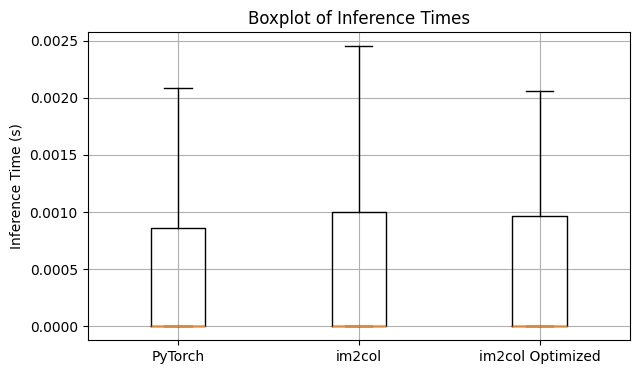


Descriptive Statistics of Inference Times:
           PyTorch       im2col  im2col Optimized
count  2000.000000  2000.000000       2000.000000
mean      0.001098     0.000940          0.000837
std       0.003252     0.002821          0.002657
min       0.000000     0.000000          0.000000
25%       0.000000     0.000000          0.000000
50%       0.000000     0.000000          0.000000
75%       0.000856     0.000999          0.000967
max       0.014627     0.015363          0.016324

Number of contiguous arrays:
im2col: 0, im2col_optimized: 0
im2col (not contiguous): 0, im2col_optimized (not contiguous): 0


In [22]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyoff
import pandas as pd

np_k1 = numpy_weights['k1'].astype(np.float32)
np_b_conv1 = numpy_weights['b_conv1'].astype(np.float32)
np_k2 = numpy_weights['k2'].astype(np.float32)
np_b_conv2 = numpy_weights['b_conv2'].astype(np.float32)
np_k3 = numpy_weights['k3'].astype(np.float32)
np_b_conv3 = numpy_weights['b_conv3'].astype(np.float32)
np_w1 = numpy_weights['w1'].astype(np.float32)
np_b1 = numpy_weights['b1'].astype(np.float32)
np_w2 = numpy_weights['w2'].astype(np.float32)
np_b2 = numpy_weights['b2'].astype(np.float32)

dict_times={}
dict_times["ctorch"]=[]
dict_times["cslow"]=[]
dict_times["cfast"]=[]
dict_times["ccm"]=[]

dict_pred={}
dict_pred["ctorch"]=[]
dict_pred["cslow"]=[]
dict_pred["cfast"]=[]
dict_pred["ccm"]=[]

c_continuity_ckeck = {
    'im2col_yes' : 0,
    'im2col_no' : 0,
    'im2col_optimized_yes' : 0,
    'im2col_optimized_no' : 0,
}

correct = 0
skip = True
loop = tqdm(range(0, test_labels.shape[0], 5), desc=" Inferring...")
for i in loop:
    c0 = test_images[i].reshape(1,1,28,28).astype(np.float32)
    torch_c0 = torch.from_numpy(c0).float()

    ############### CNN PyTorch Implementation ##################
    start_time = time.time()
    outputs = model(torch_c0)
    end_time = time.time()
    _, predicted1 = torch.max(outputs.data, 1)
    dict_times["ctorch"].append(end_time-start_time)
    dict_pred["ctorch"].append(np.array(predicted1))

    ############### CNN nested loops Implementation #####################
    # start_time = time.time()
    # c1s,mask1s = nested_loop_convolution(c0.astype(np.float32),np_k1,np_b_conv1,padding=0,stride=2)
    # c2s,mask2s = nested_loop_convolution(c1s.astype(np.float32),np_k2,np_b_conv2,padding=1,stride=2)
    # c3s,mask3s = nested_loop_convolution(c2s.astype(np.float32),np_k3,np_b_conv3,padding=0,stride=2)
    # imlps = c3s.reshape(1,-1)
    # _,_,_,res = ReLU_SoftMax_FullyConnected(imlps,np_w1,np_b1,np_w2,np_b2)
    # predicted2 = np.argmax(res,1)
    # end_time = time.time()
    # dict_times["cslow"].append(end_time-start_time)
    # dict_pred["cslow"].append(np.array(predicted2))

    ############### CNN im2col Implementation #####################
    start_time = time.time()
    c1f,mask1f = im2col_convolution(c0.astype(np.float32),np_k1,np_b_conv1,padding=0,stride=2)
    c2f,mask2f = im2col_convolution(c1f.astype(np.float32),np_k2,np_b_conv2,padding=1,stride=2)
    c3f,mask3f = im2col_convolution(c2f.astype(np.float32),np_k3,np_b_conv3,padding=0,stride=2)
    imlpf = c3f.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlpf,np_w1,np_b1,np_w2,np_b2)
    predicted3 = np.argmax(res,1)
    end_time = time.time()
    dict_times["cfast"].append(end_time-start_time)
    dict_pred["cfast"].append(np.array(predicted3))

    ############## CNN optimized im2col Implementation ###########
    start_time = time.time()
    c1c,mask1c = im2col_optimized(c0.astype(np.float32),np_k1,np_b_conv1,padding=0,stride=2)
    c2c,mask2c = im2col_optimized(c1c.astype(np.float32),np_k2,np_b_conv2,padding=1,stride=2)
    c3c,mask3c = im2col_optimized(c2c.astype(np.float32),np_k3,np_b_conv3,padding=0,stride=2)
    imlpc = c3c.reshape(1,-1)
    _,_,_,res = ReLU_SoftMax_FullyConnected(imlpc,np_w1,np_b1,np_w2,np_b2)
    predicted4 = np.argmax(res,1)
    end_time = time.time()
    dict_times["ccm"].append(end_time-start_time)
    dict_pred["ccm"].append(np.array(predicted4))

    #####################################################################################
    #### Check that outputs of Slow Approach and Fast Approach have the same results ###
    t = int(predicted1[0])
    # s = int(predicted2[0])
    f = int(predicted3[0])
    c = int(predicted4[0])

    if t == s and t == f:
        correct += 1

    #####################################################################################
    ### Keep track of the times #########################################################
    tat = round(sum(dict_times['ctorch'])/(i+1),10)
    # sat = round(sum(dict_times['cslow'])/(i+1),10)
    fat = round(sum(dict_times['cfast'])/(i+1),10)
    cat = round(sum(dict_times['ccm'])/(i+1),10)

    # loop.set_postfix(average_times =f"t: {tat} s, s: {sat} s, f: {fat} s, c: {cat} s" , correct_predictions=f"{(correct/(i+1)*100)}%")
    loop.set_postfix(average_times =f"pytorch: {tat} s, im2c: {fat} s, im2c_opt: {cat} s" , correct_predictions=f"{100*correct/(i+1)}%")

tat = np.mean(dict_times['ctorch'])
# sat = np.mean(dict_times['cslow'])
fat = np.mean(dict_times['cfast'])
cat = np.mean(dict_times['ccm'])

# print(f"Average inference time in seconds:\nPyTorch:\t{tat} s,\nnested_loops:\t{sat} s,\nim2col:\t\t{fat} s, \nim2col_optim:\t{cat} s")
print(f"Average inference time in seconds:\nPyTorch:\t{tat} s,\nim2col:\t\t{fat} s, \nim2col_optim:\t{cat} s")

# Plot times altogether

# Create interactive traces for each method
trace_torch = go.Scatter(
    y=dict_times['ctorch'],
    mode='lines+markers',
    name='PyTorch',
    line=dict(color='blue')
)
# trace_slow = go.Scatter(
#     y=dict_times['cslow'],
#     mode='lines+markers',
#     name='Nested Loops',
#     line=dict(color='orange')
# )
trace_fast = go.Scatter(
    y=dict_times['cfast'],
    mode='lines+markers',
    name='im2col',
    line=dict(color='green')
)
trace_ccm = go.Scatter(
    y=dict_times['ccm'],
    mode='lines+markers',
    name='im2col Optimized',
    line=dict(color='red')
)

data = [trace_torch, trace_fast, trace_ccm]

layout = go.Layout(
    title='Inference Time Comparison (Interactive)',
    xaxis=dict(title='Batch Index'),
    yaxis=dict(title='Inference Time (s)'),
    width=1400,
    height=500,
    legend=dict(x=0, y=1),
    hovermode='x unified'
)

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

# Also plot some boxplots for better visualization
plt.figure(figsize=(7, 4))
plt.boxplot([dict_times['ctorch'], dict_times['cfast'], dict_times['ccm']],
            tick_labels=['PyTorch', 'im2col', 'im2col Optimized'],
            showfliers=False)
plt.ylabel('Inference Time (s)')
plt.title('Boxplot of Inference Times')
plt.grid()
plt.show()

df_times = pd.DataFrame({
    'PyTorch': dict_times['ctorch'],
    # 'Nested Loops': dict_times['cslow'],
    'im2col': dict_times['cfast'],
    'im2col Optimized': dict_times['ccm']
})
print("\nDescriptive Statistics of Inference Times:")
print(df_times.describe())

# Print the number of contiguous arrays
print("\nNumber of contiguous arrays:")
print(f"im2col: {c_continuity_ckeck['im2col_yes']}, im2col_optimized: {c_continuity_ckeck['im2col_optimized_yes']}")
print(f"im2col (not contiguous): {c_continuity_ckeck['im2col_no']}, im2col_optimized (not contiguous): {c_continuity_ckeck['im2col_optimized_no']}")

## Training

In this panel the approach is tested to see if it learns or not. the test uses first just one image, then the first 100 for each eopch, in order to see if the loss descends during the training

### NumPy Model Training: Weights Initialization

For training our NumPy CNNs from scratch, weights and biases are initialized randomly.
The shapes are taken from `numpy_weights` (derived from the PyTorch model) to maintain architectural consistency. `np.random.rand()` provides initial values (uniform in [0,1)). While more advanced initializers exist, this suffices for observing basic learning.

In [16]:
k1 = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
bc1 = np.random.rand(int(numpy_weights['b_conv1'].flatten().shape[0])).reshape(numpy_weights['b_conv1'].shape)
k2 = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
bc2 = np.random.rand(int(numpy_weights['b_conv2'].flatten().shape[0])).reshape(numpy_weights['b_conv2'].shape)
k3 = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
bc3 = np.random.rand(int(numpy_weights['b_conv3'].flatten().shape[0])).reshape(numpy_weights['b_conv3'].shape)
w1 = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
b1 = np.random.rand(int(numpy_weights['b1'].flatten().shape[0])).reshape(numpy_weights['b1'].shape)
w2 = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)
b2 = np.random.rand(int(numpy_weights['b2'].flatten().shape[0])).reshape(numpy_weights['b2'].shape)

In [17]:
def avgList(listA):
    sum_li = sum(listA)
    length_li = len(listA)
    return round(sum_li/length_li,4)

#### Same Image

### Training the "Slow" NumPy CNN (Single Image Test)

This tests training the loop-based `nested_loop_convolution` and `Slow_ReLU_Gradient` implementations on a single image.

**Per-Epoch Steps:**
1.  **Forward Pass:**
    *   `c0 -> nested_loop_convolution (k1,bc1,p=0,s=2) -> c1s`
    *   `c1s -> nested_loop_convolution (k2,bc2,p=1,s=2) -> c2s`
    *   `c2s -> nested_loop_convolution (k3,bc3,p=0,s=2) -> c3s`
    *   `c3s -> flatten -> imlps -> ReLU_SoftMax_FullyConnected -> sa` (probabilities)
2.  **Loss:** `loss = crossEntropy(sa, true_label)`
3.  **Backward Pass:** Gradients are computed using `ReLU_SoftMax_FC_Backward` for MLP, then `Slow_ReLU_Gradient` is called sequentially for conv layers, propagating gradients backward.
4.  **Weight Update:** Parameters updated via $W_{new} = W_{old} - \eta \cdot \frac{\partial L}{\partial W_{old}}$.

The loss is plotted to observe learning. The padding and stride parameters in `nested_loop_convolution` calls are set to match the PyTorch model architecture, ensuring the flattened features `imlps` have the correct dimension (2048) for the MLP.

100%|██████████| 20/20 [01:30<00:00,  4.54s/it, avgBackward=3.3668 s, avgForward=1.168 s, pendence=[-0.02896908]] 


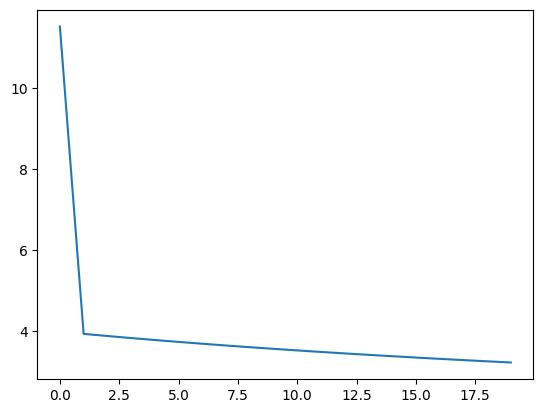

In [ ]:
import matplotlib.pyplot as plt
ToBeTrained = True
if ToBeTrained:
    avg_loss = []
    forward_time = []
    backward_time = []
    numEpochs = 20
    bs = 1
    lr = 0.001
    loop = tqdm(range(numEpochs))
    for i in loop:
        c0 = train_images[0].reshape(1,1,28,28).astype(np.float32)
        
        # Forward
        sfts = time.time() # slow forward time start
        c1s,mask1s = nested_loop_convolution(c0.astype(np.float32),k1,bc1,pad=0,stride=2)
        c2s,mask2s = nested_loop_convolution(c1s.astype(np.float32),k2,bc2,pad=1,stride=2)
        c3s,mask3s = nested_loop_convolution(c2s.astype(np.float32),k3,bc3,pad=0,stride=2)

        imlps = c3s.reshape(1,-1)
        fl,fa,sl,sa = ReLU_SoftMax_FullyConnected(imlps,w1,b1,w2,b2)
        sfte = time.time() # slow forward time end
        sft = sfte - sfts
        forward_time.append(sft)
        
        # Loss
        loss = crossEntropy(sa,train_labels[0])
        avg_loss.append(loss)

        # Backward
        sbts = time.time() # slow backward time start
        dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2 = ReLU_SoftMax_FC_Backward(bs,sa,train_labels[0],w1,w2,fa,fl,imlps)
        dL_i_mlp = dL_i_mlp.reshape(c3s.shape)

        gi3,gk3,gb3 = Slow_ReLU_Gradient(c2s,dL_i_mlp,k3,mask3s,pad=0,stride=2)

        gi2,gk2,gb2 = Slow_ReLU_Gradient(c1s,gi3,k2,mask2s,pad=1,stride=2)
        gi1,gk1,gb1 = Slow_ReLU_Gradient(c0,gi2,k1,mask1s,pad=0,stride=2)
        sbte = time.time() # slow backward time end
        sbt = sbte - sbts
        backward_time.append(sbt)

        # Weights update
        w1 -= lr*dL_dw1
        b1 -= lr*dL_db1
        w2 -= lr*dL_dw2
        b2 -= lr*dL_db2
        k3 -= lr*gk3
        k2 -= lr*gk2
        k1 -= lr*gk1
        bc3 -= lr*gb3.reshape(-1)
        bc2 -= lr*gb2.reshape(-1)
        bc1 -= lr*gb1.reshape(-1)
        
        if len(avg_loss) >= 2:
            loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{avgList(forward_time)} s", avgBackward=f"{avgList(backward_time)} s" )

    plt.plot(avg_loss)
    plt.show()
# 2.64135 <-> 2.64095
# 2.64055 <-> 2.64020
# 2.64015 <-> 2.63980
# 2.63910 <-> 2.63840

These are the results for 20 epochs of one image:
- average forward time : 3.6265 s
- average backward time : 9.8262 s

Plot of the loss:

<img src="images\Slow Approach.png">


### Test for Fast approach

In this panel the approach is tested to see if it learns or not. the test uses first just one image, then the first 100 for each eopch, in order to see if the loss descends during the training

#### Weights Initialization

In [42]:
def initialize_weights():
    weights = {}

    weights['k1'] = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
    weights['bc1'] = np.random.rand(int(numpy_weights['b_conv1'].flatten().shape[0])).reshape(numpy_weights['b_conv1'].shape)
    weights['k2'] = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
    weights['bc2'] = np.random.rand(int(numpy_weights['b_conv2'].flatten().shape[0])).reshape(numpy_weights['b_conv2'].shape)
    weights['k3'] = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
    weights['bc3'] = np.random.rand(int(numpy_weights['b_conv3'].flatten().shape[0])).reshape(numpy_weights['b_conv3'].shape)
    weights['w1'] = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
    weights['b1'] = np.random.rand(int(numpy_weights['b1'].flatten().shape[0])).reshape(numpy_weights['b1'].shape)
    weights['w2'] = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)
    weights['b2'] = np.random.rand(int(numpy_weights['b2'].flatten().shape[0])).reshape(numpy_weights['b2'].shape)

    return weights

def initialize_weights_no_bias():
    weights = {}

    weights['k1'] = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
    weights['k2'] = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
    weights['k3'] = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
    weights['w1'] = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
    weights['w2'] = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)

    return weights

#### Same Image

### Training the "Fast" NumPy CNN (Single Image Test)

This tests training using the Im2Col-based `im2col_convolution` and the revised `Fast_ReLU_Gradient` (from cell `c808bdb6`) on a single image.

**Per-Epoch Steps (differences from "Slow" are conv/grad functions):**
1.  **Forward Pass:**
    *   `c0 -> im2col_convolution (k1,bc1,p=0,s=2) -> c1s`
    *   `c1s -> im2col_convolution (k2,bc2,p=1,s=2) -> c2s`
    *   `c2s -> im2col_convolution (k3,bc3,p=0,s=2) -> c3s`
    *   `c3s -> flatten -> imlps -> ReLU_SoftMax_FullyConnected -> sa`
2.  **Loss:** `loss = crossEntropy(sa, true_label)`
3.  **Backward Pass:** `ReLU_SoftMax_FC_Backward` for MLP, then `Fast_ReLU_Gradient` (using `sliding_window_view` for `gi` and `gk`) for conv layers.
4.  **Weight Update:** Standard gradient descent.

The loss is plotted. Consistent padding/stride ensures correct feature dimensions for the MLP. This setup tests the learning capability and performance of the more optimized NumPy convolution functions.

In [ ]:
import matplotlib.pyplot as plt
avg_loss = []
forward_time = []
backward_time = []
numEpochs = 500
bs = 1
lr = 0.001

k1 = np.random.rand(int(numpy_weights['k1'].flatten().shape[0])).reshape(numpy_weights['k1'].shape)
bc1 = np.random.rand(int(numpy_weights['b_conv1'].flatten().shape[0])).reshape(numpy_weights['b_conv1'].shape)
k2 = np.random.rand(int(numpy_weights['k2'].flatten().shape[0])).reshape(numpy_weights['k2'].shape)
bc2 = np.random.rand(int(numpy_weights['b_conv2'].flatten().shape[0])).reshape(numpy_weights['b_conv2'].shape)
k3 = np.random.rand(int(numpy_weights['k3'].flatten().shape[0])).reshape(numpy_weights['k3'].shape)
bc3 = np.random.rand(int(numpy_weights['b_conv3'].flatten().shape[0])).reshape(numpy_weights['b_conv3'].shape)
w1 = np.random.rand(int(numpy_weights['w1'].flatten().shape[0])).reshape(numpy_weights['w1'].shape)
b1 = np.random.rand(int(numpy_weights['b1'].flatten().shape[0])).reshape(numpy_weights['b1'].shape)
w2 = np.random.rand(int(numpy_weights['w2'].flatten().shape[0])).reshape(numpy_weights['w2'].shape)
b2 = np.random.rand(int(numpy_weights['b2'].flatten().shape[0])).reshape(numpy_weights['b2'].shape)

loop = tqdm(range(numEpochs))
for i in loop:
    c0 = train_images[0].reshape(1,1,28,28).astype(np.float32)
    
    # Forward
    sfts = time.time() # slow forward time start
    c1s,mask1s = im2col_convolution(c0.astype(np.float32),k1,bc1,padding=0,stride=2)
    c2s,mask2s = im2col_convolution(c1s.astype(np.float32),k2,bc2,padding=1,stride=2)
    c3s,mask3s = im2col_convolution(c2s.astype(np.float32),k3,bc3,padding=0,stride=2)
    imlps = c3s.reshape(1,-1)
    fl,fa,sl,sa = ReLU_SoftMax_FullyConnected(imlps,w1,b1,w2,b2)
    sfte = time.time() # slow forward time end
    sft = sfte - sfts
    forward_time.append(sft)
    
    # Loss
    loss = crossEntropy(sa,train_labels[0])
    avg_loss.append(loss)

    # Backward
    sbts = time.time() # slow backward time start
    dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2 = ReLU_SoftMax_FC_Backward(bs,sa,train_labels[0],w1,w2,fa,fl,imlps)
    dL_i_mlp = dL_i_mlp.reshape(c3s.shape)

    gi3,gk3,gb3 = im2col_gradient(c2s,dL_i_mlp,k3,mask3s,padding=0,stride=2)
    gi2,gk2,gb2 = im2col_gradient(c1s,gi3,k2,mask2s,padding=1,stride=2)
    gi1,gk1,gb1 = im2col_gradient(c0,gi2,k1,mask1s,padding=0,stride=2)
    sbte = time.time() # slow backward time end
    sbt = sbte - sbts
    backward_time.append(sbt)

    # Weights update
    w1 -= lr*dL_dw1
    b1 -= lr*dL_db1
    w2 -= lr*dL_dw2
    b2 -= lr*dL_db2
    k3 -= lr*gk3
    k2 -= lr*gk2
    k1 -= lr*gk1
    bc3 -= lr*gb3
    bc2 -= lr*gb2
    bc1 -= lr*gb1
    
    if len(avg_loss) > 2:
        loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{avgList(forward_time)} s", avgBackward=f"{avgList(backward_time)} s" )

plt.plot(avg_loss)
plt.show()

No bias version

Initial weights: 6.785682802873736, 52.89028727703807, 106.03498594875933, 415.73973189549963, 28.95009463759042


100%|██████████| 6/6 [00:00<00:00, 68.89it/s, avgBackward=0.006081899007161458 s, avgForward=0.0019659201304117837 s, pendence=0.0]


--- Epoch 1 ReLU Masks ---
  mask1s active: 29.59%
  mask2s active: 35.94%
  mask3s active: 68.75%
  MLP ReLU active: 100.00%

sa[0]: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
train_labels[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

--- Epoch 1 Intermediate Gradients ---
  dL_i_mlp (to conv3) norm: 9.66e+01, sum: 2.03e+03
  gi3 (to conv2) norm: 3.27e+03, sum: 1.70e+05
  gi2 (to conv1) norm: 1.05e+05, sum: 5.61e+06
  gi1 (to input) norm: 4.69e+05, sum: 6.98e+06

--- Epoch 1 Gradients BEFORE update ---
  gk1 norm: 5.68e+05, sum: 6.41e+06
  gk2 norm: 7.42e+04, sum: 6.49e+06
  gk3 norm: 5.59e+04, sum: 6.48e+06
  dL_dw1 norm: 9.08e+05, sum: 6.88e+06
  dL_dw2 norm: 4.01e+07, sum: 2.33e-10

Weights after first update:
  k1 norm: 2.809095466308095, sum: 0.35322747536575383
  k2 norm: 51.63819625825995, sum: 4029.3705267815194
  k3 norm: 104.26338406392159, sum: 16359.483954756197
  w1 norm: 412.98911754900695, sum: 255819.38111464973
  w2 norm: 402.2759134791379, sum: 1234.8840510032333
Difference in weights:

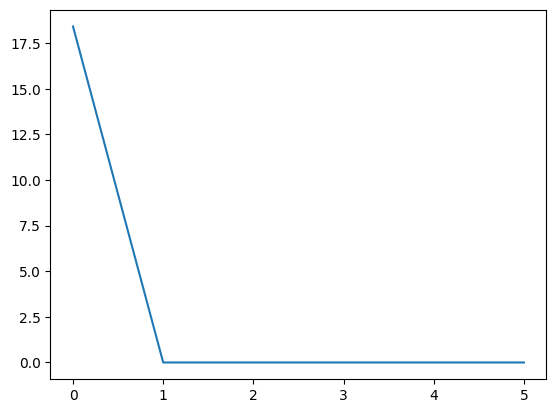

In [82]:
import matplotlib.pyplot as plt
avg_loss = []
forward_time = []
backward_time = []
numEpochs = 6
bs = 1
lr = 0.00001

# fix a seed for reproducibility
np.random.seed(123)

k1 = np.random.rand(*numpy_weights['k1'].shape)
k2 = np.random.rand(*numpy_weights['k2'].shape)
k3 = np.random.rand(*numpy_weights['k3'].shape)
w1 = np.random.rand(*numpy_weights['w1'].shape)
w2 = np.random.rand(*numpy_weights['w2'].shape)

print(f"Initial weights: {np.linalg.norm(k1-numpy_weights['k1'])}, {np.linalg.norm(k2-numpy_weights['k2'])}, {np.linalg.norm(k3-numpy_weights['k3'])}, {np.linalg.norm(w1-numpy_weights['w1'])}, {np.linalg.norm(w2-numpy_weights['w2'])}")

loop = tqdm(range(numEpochs))
for i in loop:
    c0 = (train_images[0].reshape(1,1,28,28) / 255.0).astype(np.float64)
    current_train_label = train_labels[0].astype(np.float64)

    # Forward
    sfts = time.time() # slow forward time start
    c1s,mask1s = im2col_optimized_float64_no_bias(c0.astype(np.float64),k1,None,padding=0,stride=2)
    c2s,mask2s = im2col_optimized_float64_no_bias(c1s.astype(np.float64),k2,None,padding=1,stride=2)
    c3s,mask3s = im2col_optimized_float64_no_bias(c2s.astype(np.float64),k3,None,padding=0,stride=2)
    imlps = c3s.reshape(1,-1)
    fl,fa,sl,sa = ReLU_SoftMax_FC_no_bias(imlps,w1,w2)
    sfte = time.time() # slow forward time end
    sft = sfte - sfts
    forward_time.append(sft)

    print(f"\n--- Epoch {i+1} ReLU Masks ---")
    print(f"  mask1s active: {np.mean(mask1s)*100:.2f}%")
    print(f"  mask2s active: {np.mean(mask2s)*100:.2f}%")
    print(f"  mask3s active: {np.mean(mask3s)*100:.2f}%")
    # Anche per la ReLU nel MLP (fl > 0)
    print(f"  MLP ReLU active: {np.mean((fl > 0))*100:.2f}%\n")

    print(f"sa[0]: {sa[0]}")
    print(f"train_labels[0]: {current_train_label}")
    
    # Loss
    loss = crossEntropy(sa[0], current_train_label)
    avg_loss.append(loss)

    # Backward
    sbts = time.time() # slow backward time start
    print(f"\n--- Epoch {i+1} Intermediate Gradients ---")
    dL_i_mlp,dL_dw1,dL_dw2 = ReLU_SoftMax_FC_Backward_no_bias(bs,sa,train_labels[0].reshape(1, -1),w1,w2,fa,fl,imlps)
    dL_i_mlp = dL_i_mlp.reshape(c3s.shape)
    print(f"  dL_i_mlp (to conv3) norm: {np.linalg.norm(dL_i_mlp):.2e}, sum: {np.sum(dL_i_mlp):.2e}")

    gi3,gk3 = im2col_gradient_optimized_float64_no_bias(c2s,dL_i_mlp,k3,mask3s,padding=0,stride=2)
    print(f"  gi3 (to conv2) norm: {np.linalg.norm(gi3):.2e}, sum: {np.sum(gi3):.2e}")

    gi2,gk2 = im2col_gradient_optimized_float64_no_bias(c1s,gi3,k2,mask2s,padding=1,stride=2)
    print(f"  gi2 (to conv1) norm: {np.linalg.norm(gi2):.2e}, sum: {np.sum(gi2):.2e}")

    gi1,gk1 = im2col_gradient_optimized_float64_no_bias(c0,gi2,k1,mask1s,padding=0,stride=2)
    print(f"  gi1 (to input) norm: {np.linalg.norm(gi1):.2e}, sum: {np.sum(gi1):.2e}")

    sbte = time.time() # slow backward time end
    sbt = sbte - sbts
    backward_time.append(sbt)


    print(f"\n--- Epoch {i+1} Gradients BEFORE update ---")
    print(f"  gk1 norm: {np.linalg.norm(gk1):.2e}, sum: {np.sum(gk1):.2e}")
    print(f"  gk2 norm: {np.linalg.norm(gk2):.2e}, sum: {np.sum(gk2):.2e}")
    print(f"  gk3 norm: {np.linalg.norm(gk3):.2e}, sum: {np.sum(gk3):.2e}")
    print(f"  dL_dw1 norm: {np.linalg.norm(dL_dw1):.2e}, sum: {np.sum(dL_dw1):.2e}")
    print(f"  dL_dw2 norm: {np.linalg.norm(dL_dw2):.2e}, sum: {np.sum(dL_dw2):.2e}")

    # Gradient clipping
    # max_grad_norm = 5
    # all_grads_flat = np.concatenate([
    #     gk1.ravel(), gk2.ravel(), gk3.ravel(),
    #     dL_dw1.ravel(), dL_dw2.ravel()
    # ])
    # norm = np.linalg.norm(all_grads_flat)
    # if norm > max_grad_norm:
    #     clip_factor = max_grad_norm / (norm + 1e-6) # Aggiungi epsilon per evitare divisione per zero
    #     gk1 *= clip_factor
    #     gk2 *= clip_factor
    #     gk3 *= clip_factor
    #     dL_dw1 *= clip_factor
    #     dL_dw2 *= clip_factor

    # Weights update
    w1 -= lr*dL_dw1
    # b1 -= lr*dL_db1
    w2 -= lr*dL_dw2
    # b2 -= lr*dL_db2
    k3 -= lr*gk3
    k2 -= lr*gk2
    k1 -= lr*gk1
    # bc3 -= lr*gb3
    # bc2 -= lr*gb2
    # bc1 -= lr*gb1

    if i == 0:
        print("\nWeights after first update:")
        print(f"  k1 norm: {np.linalg.norm(k1)}, sum: {np.sum(k1)}")
        print(f"  k2 norm: {np.linalg.norm(k2)}, sum: {np.sum(k2)}")
        print(f"  k3 norm: {np.linalg.norm(k3)}, sum: {np.sum(k3)}")
        print(f"  w1 norm: {np.linalg.norm(w1)}, sum: {np.sum(w1)}")
        print(f"  w2 norm: {np.linalg.norm(w2)}, sum: {np.sum(w2)}")
    
    print(f"Difference in weights: {np.linalg.norm(k1-numpy_weights['k1'])}, {np.linalg.norm(k2-numpy_weights['k2'])}, {np.linalg.norm(k3-numpy_weights['k3'])}, {np.linalg.norm(w1-numpy_weights['w1'])}, {np.linalg.norm(w2-numpy_weights['w2'])}")

    if len(avg_loss) > 2:
        loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{np.mean(forward_time)} s", avgBackward=f"{np.mean(backward_time)} s" )

plt.plot(avg_loss)
plt.show()


Initial weights: 7.315055162435693, 52.85940395184716, 106.201916573569, 416.42291107765806, 29.498981615590733


100%|██████████| 6/6 [00:00<00:00, 68.58it/s, avgBackward=0.005353411038716634 s, avgForward=0.002889712651570638 s, pendence=0.0]


--- Epoch 1 ReLU Masks ---
  mask1s active: 100.00%
  mask2s active: 100.00%
  mask3s active: 100.00%
  MLP ReLU active: 100.00%

sa[0]: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
train_labels[0]: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Loss: 18.4207

--- Epoch 1 Intermediate Gradients ---
  dL_i_mlp (to conv3) norm: 1.87e+02, sum: 7.68e+03
  gi3 (to conv2) norm: 1.55e+04, sum: 9.86e+05
  gi2 (to conv1) norm: 6.14e+05, sum: 4.84e+07
  gi1 (to input) norm: 3.52e+06, sum: 9.81e+07

--- Epoch 1 Gradients BEFORE update ---
  gk1 norm: 2.38e+06, sum: 2.69e+07
  gk2 norm: 7.85e+05, sum: 6.62e+07
  gk3 norm: 3.76e+05, sum: 6.69e+07
  dL_dw1 norm: 1.43e+06, sum: 6.61e+07
  dL_dw2 norm: 9.93e+07, sum: 1.86e-09

Weights after first update:
  k1 norm: 2377.4178445994216, sum: -26868.608666005945
  b_conv1 norm: 2.6445735723052763, sum: 12.827401165819861
  k2 norm: 744.0920090682417, sum: -62066.437334830174
  b_conv2 norm: 4.802111713899647, sum: 32.64921560393243
  k3 norm: 292.6565219677304, sum: -50485.1136461

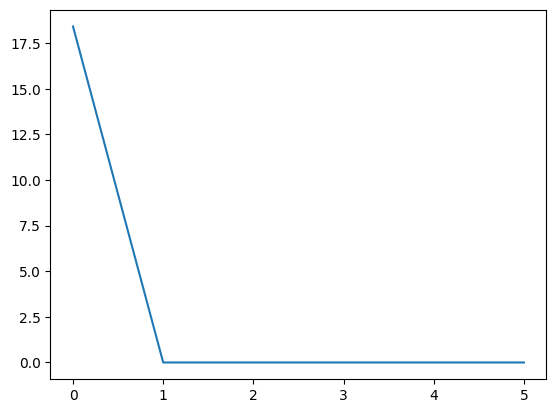

In [95]:
import matplotlib.pyplot as plt
avg_loss = []
forward_time = []
backward_time = []
numEpochs = 6
bs = 1
lr = 0.001

# fix a seed for reproducibility
np.random.seed(4567)

# k1 = np.random.normal(0,1,(numpy_weights['k1'].shape))
# b_conv1 = np.random.normal(0,1,(numpy_weights['b_conv1'].shape))
# k2 = np.random.normal(0,1,(numpy_weights['k2'].shape))
# b_conv2 = np.random.normal(0,1,(numpy_weights['b_conv2'].shape))
# k3 = np.random.normal(0,1,(numpy_weights['k3'].shape))
# b_conv3 = np.random.normal(0,1,(numpy_weights['b_conv3'].shape))
# w1 = np.random.normal(0,1,(numpy_weights['w1'].shape))
# b1 = np.random.normal(0,1,(numpy_weights['b1'].shape))
# w2 = np.random.normal(0,1,(numpy_weights['w2'].shape))
# b2 = np.random.normal(0,1,(numpy_weights['b2'].shape))

k1 = np.random.rand(*numpy_weights['k1'].shape)
b_conv1 = np.random.rand(*numpy_weights['b_conv1'].shape)
k2 = np.random.rand(*numpy_weights['k2'].shape)
b_conv2 = np.random.rand(*numpy_weights['b_conv2'].shape)
k3 = np.random.rand(*numpy_weights['k3'].shape)
b_conv3 = np.random.rand(*numpy_weights['b_conv3'].shape)
w1 = np.random.rand(*numpy_weights['w1'].shape)
b1 = np.random.rand(*numpy_weights['b1'].shape)
w2 = np.random.rand(*numpy_weights['w2'].shape)
b2 = np.random.rand(*numpy_weights['b2'].shape)

print(f"Initial weights: {np.linalg.norm(k1-numpy_weights['k1'])}, {np.linalg.norm(k2-numpy_weights['k2'])}, {np.linalg.norm(k3-numpy_weights['k3'])}, {np.linalg.norm(w1-numpy_weights['w1'])}, {np.linalg.norm(w2-numpy_weights['w2'])}")

loop = tqdm(range(numEpochs))
for i in loop:
    c0 = (train_images[0].reshape(1,1,28,28) / 255.0).astype(np.float64)
    current_train_label = train_labels[0].astype(np.float64)

    # Forward
    sfts = time.time() # slow forward time start
    c1s,mask1s = im2col_optimized(c0.astype(np.float64),k1,b_conv1,padding=0,stride=2)
    c2s,mask2s = im2col_optimized(c1s.astype(np.float64),k2,b_conv2,padding=1,stride=2)
    c3s,mask3s = im2col_optimized(c2s.astype(np.float64),k3,b_conv3,padding=0,stride=2)
    imlps = c3s.reshape(1,-1)
    fl,fa,sl,sa = ReLU_SoftMax_FullyConnected(imlps,w1,b1,w2,b2)
    sfte = time.time() # slow forward time end
    sft = sfte - sfts
    forward_time.append(sft)

    print(f"\n--- Epoch {i+1} ReLU Masks ---")
    print(f"  mask1s active: {np.mean(mask1s)*100:.2f}%")
    print(f"  mask2s active: {np.mean(mask2s)*100:.2f}%")
    print(f"  mask3s active: {np.mean(mask3s)*100:.2f}%")
    # Anche per la ReLU nel MLP (fl > 0)
    print(f"  MLP ReLU active: {np.mean((fl > 0))*100:.2f}%\n")

    print(f"sa[0]: {sa[0]}")
    print(f"train_labels[0]: {current_train_label}")
    
    # Loss
    loss = crossEntropy(sa[0], current_train_label)

    print(f"Loss: {loss:.4f}")

    avg_loss.append(loss)

    # Backward
    sbts = time.time() # slow backward time start
    print(f"\n--- Epoch {i+1} Intermediate Gradients ---")
    dL_i_mlp,dL_dw1,dL_db1,dL_dw2,dL_db2 = ReLU_SoftMax_FC_Backward(bs,sa,train_labels[0].reshape(1, -1),w1,w2,fa,fl,imlps)
    dL_i_mlp = dL_i_mlp.reshape(c3s.shape)
    print(f"  dL_i_mlp (to conv3) norm: {np.linalg.norm(dL_i_mlp):.2e}, sum: {np.sum(dL_i_mlp):.2e}")

    gi3,gk3,gb3 = im2col_gradient_optimized(c2s,dL_i_mlp,k3,mask3s,padding=0,stride=2)
    print(f"  gi3 (to conv2) norm: {np.linalg.norm(gi3):.2e}, sum: {np.sum(gi3):.2e}")

    gi2,gk2,gb2 = im2col_gradient_optimized(c1s,gi3,k2,mask2s,padding=1,stride=2)
    print(f"  gi2 (to conv1) norm: {np.linalg.norm(gi2):.2e}, sum: {np.sum(gi2):.2e}")

    gi1,gk1,gb1 = im2col_gradient_optimized(c0,gi2,k1,mask1s,padding=0,stride=2)
    print(f"  gi1 (to input) norm: {np.linalg.norm(gi1):.2e}, sum: {np.sum(gi1):.2e}")

    sbte = time.time() # slow backward time end
    sbt = sbte - sbts
    backward_time.append(sbt)


    print(f"\n--- Epoch {i+1} Gradients BEFORE update ---")
    print(f"  gk1 norm: {np.linalg.norm(gk1):.2e}, sum: {np.sum(gk1):.2e}")
    print(f"  gk2 norm: {np.linalg.norm(gk2):.2e}, sum: {np.sum(gk2):.2e}")
    print(f"  gk3 norm: {np.linalg.norm(gk3):.2e}, sum: {np.sum(gk3):.2e}")
    print(f"  dL_dw1 norm: {np.linalg.norm(dL_dw1):.2e}, sum: {np.sum(dL_dw1):.2e}")
    print(f"  dL_dw2 norm: {np.linalg.norm(dL_dw2):.2e}, sum: {np.sum(dL_dw2):.2e}")

    # Gradient clipping
    # max_grad_norm = 5
    # all_grads_flat = np.concatenate([
    #     gk1.ravel(), gk2.ravel(), gk3.ravel(),
    #     dL_dw1.ravel(), dL_dw2.ravel()
    # ])
    # norm = np.linalg.norm(all_grads_flat)
    # if norm > max_grad_norm:
    #     clip_factor = max_grad_norm / (norm + 1e-6) # Aggiungi epsilon per evitare divisione per zero
    #     gk1 *= clip_factor
    #     gk2 *= clip_factor
    #     gk3 *= clip_factor
    #     dL_dw1 *= clip_factor
    #     dL_dw2 *= clip_factor

    # Weights update
    w1 -= lr*dL_dw1
    b1 -= lr*dL_db1
    w2 -= lr*dL_dw2
    b2 -= lr*dL_db2
    k3 -= lr*gk3
    k2 -= lr*gk2
    k1 -= lr*gk1
    bc3 -= lr*gb3
    bc2 -= lr*gb2
    bc1 -= lr*gb1

    if i == 0:
        print("\nWeights after first update:")
        print(f"  k1 norm: {np.linalg.norm(k1)}, sum: {np.sum(k1)}")
        print(f"  b_conv1 norm: {np.linalg.norm(b_conv1)}, sum: {np.sum(b_conv1)}")
        print(f"  k2 norm: {np.linalg.norm(k2)}, sum: {np.sum(k2)}")
        print(f"  b_conv2 norm: {np.linalg.norm(b_conv2)}, sum: {np.sum(b_conv2)}")
        print(f"  k3 norm: {np.linalg.norm(k3)}, sum: {np.sum(k3)}")
        print(f"  b_conv3 norm: {np.linalg.norm(b_conv3)}, sum: {np.sum(b_conv3)}")
        print(f"  w1 norm: {np.linalg.norm(w1)}, sum: {np.sum(w1)}")
        print(f"  b1 norm: {np.linalg.norm(b1)}, sum: {np.sum(b1)}")
        print(f"  w2 norm: {np.linalg.norm(w2)}, sum: {np.sum(w2)}")
        print(f"  b2 norm: {np.linalg.norm(b2)}, sum: {np.sum(b2)}")
    
    print(f"Difference in weights: {np.linalg.norm(k1-numpy_weights['k1'])}, {np.linalg.norm(k2-numpy_weights['k2'])}, {np.linalg.norm(k3-numpy_weights['k3'])}, {np.linalg.norm(w1-numpy_weights['w1'])}, {np.linalg.norm(w2-numpy_weights['w2'])}")

    if len(avg_loss) > 2:
        loop.set_postfix(pendence=f" {avg_loss[i]-avg_loss[i-1]}",avgForward=f"{np.mean(forward_time)} s", avgBackward=f"{np.mean(backward_time)} s" )

plt.plot(avg_loss)
plt.show()


### Compare all implementations (training and test)

In [109]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# --- PyTorch CNNDataset (from notebook cell 5ff84faf, potentially commented out) ---
class CNNDataset(Dataset):
    def __init__(self, digits, labels, transform=None):
        assert len(digits) == len(labels), "Number of digits and labels doesn't match"
        self.digits = digits
        self.labels = labels
        self.transform = transform 

    def __len__(self):
        return len(self.digits)

    def __getitem__(self, idx):
        digit = self.digits[idx]
        label = self.labels[idx]
        # PyTorch Conv2d expects (B, C, H, W)
        # MNIST images are (H, W), need to add channel dim
        digit = digit.unsqueeze(0) # (H, W) -> (1, H, W)
        return digit, label

# --- Training Functions ---

def train_pytorch_cnn(train_images_np, train_labels_np, test_images_np, test_labels_np, num_epochs=5, batch_size=128, learning_rate=0.001):
    print("\n--- Training PyTorch CNN ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Prepare data
    tri = torch.from_numpy(train_images_np).float() / 255.0
    trl = torch.from_numpy(train_labels_np).float() # Already one-hot
    tsi = torch.from_numpy(test_images_np).float() / 255.0
    tsl = torch.from_numpy(test_labels_np).float()   # Already one-hot

    train_dataset = CNNDataset(tri, trl)
    test_dataset = CNNDataset(tsi, tsl)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN_no_bias(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_accuracies = []

    with torch.no_grad():
        sample_input = tri[0].unsqueeze(0).to(device)
        sample_label = trl[0].unsqueeze(0).to(device)
        sample_output = model(sample_input)
        initial_loss = criterion(sample_output, torch.max(sample_label, 1)[1])
        print(f"Initial loss: {initial_loss.item():.4f}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        epoch_start_time = time.time()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s - Training Loss: {epoch_loss:.4f}")

        # Test evaluation
        model.eval()
        test_loss_val = 0.0 # Renamed to avoid conflict with outer scope 'loss'
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                current_test_loss = criterion(outputs, labels) # Renamed
                test_loss_val += current_test_loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                _, true_labels_indices = torch.max(labels, 1)
                total += true_labels_indices.size(0)
                correct += (predicted == true_labels_indices).sum().item()
        
        avg_test_loss = test_loss_val / len(test_loader.dataset)
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy:.2f}%")

    print("PyTorch Training Complete.")
    
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
    # plt.title('PyTorch Training Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.grid(True)

    # plt.subplot(1, 2, 2)
    # plt.plot(range(1, num_epochs + 1), test_accuracies, marker='o', color='r')
    # plt.title('PyTorch Test Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy (%)')
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    
    return model

def train_numpy_cnn(train_images_np, train_labels_np, test_images_np, test_labels_np,
                      conv_forward_fn, conv_backward_fn,
                      model_name, initial_np_weights,
                      num_epochs=5, batch_size=64, learning_rate=0.001):
    print(f"\n--- Training NumPy CNN: {model_name} ---")

    k1, bc1 = np.copy(initial_np_weights['k1']), np.copy(initial_np_weights['bc1'])
    k2, bc2 = np.copy(initial_np_weights['k2']), np.copy(initial_np_weights['bc2'])
    k3, bc3 = np.copy(initial_np_weights['k3']), np.copy(initial_np_weights['bc3'])
    w1, b1_fc = np.copy(initial_np_weights['w1']), np.copy(initial_np_weights['b1'])
    w2, b2_fc = np.copy(initial_np_weights['w2']), np.copy(initial_np_weights['b2'])

    num_samples = train_images_np.shape[0]
    epoch_losses = []

    c0 = train_images_np[0].reshape(1, 1, 28, 28) // 255
    c1, mask1 = conv_forward_fn(c0, k1, bc1, padding=0, stride=2, applyReLU=True)
    c2, mask2 = conv_forward_fn(c1, k2, bc2, padding=1, stride=2, applyReLU=True)
    c3, mask3 = conv_forward_fn(c2, k3, bc3, padding=0, stride=2, applyReLU=True)

    input_to_mlp = c3.reshape(1, -1)
    fl, fa, sl, sa = ReLU_SoftMax_FullyConnected(input_to_mlp, w1, b1_fc, w2, b2_fc)

    initial_loss = crossEntropy(sa[0], train_labels_np[0])
    print(f"{initial_loss:.4f}")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        current_epoch_loss = 0.0

        progress_bar = tqdm(range(0, num_samples, batch_size), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        
        num_batches_processed = 0

        for i in progress_bar:
            num_batches_processed += 1
            batch_images = train_images[i:i+batch_size].reshape(batch_size, 1, 28, 28) // 255
            batch_labels = train_labels[i:i+batch_size]
            
            c0 = batch_images.astype(np.float64)

            # --- Forward Pass ---
            c1, mask1 = conv_forward_fn(c0, k1, bc1, padding=0, stride=2, applyReLU=True)
            c2, mask2 = conv_forward_fn(c1, k2, bc2, padding=1, stride=2, applyReLU=True)
            c3, mask3 = conv_forward_fn(c2, k3, bc3, padding=0, stride=2, applyReLU=True)

            input_to_mlp = c3.reshape(batch_size, -1)
            fl, fa, sl, sa = ReLU_SoftMax_FullyConnected(input_to_mlp, w1, b1, w2, b2)
            
            batch_loss_val = 0

            for j_idx in range(batch_size):
                batch_loss_val += crossEntropy(sa[j_idx], batch_labels[j_idx])
            batch_loss_val /= batch_size
            current_epoch_loss += batch_loss_val

            # --- Backward Pass ---
            dL_i_mlp, dL_dw1, dL_db1, dL_dw2, dL_db2 = ReLU_SoftMax_FC_Backward(batch_size, sa, batch_labels, w1, w2, fa, fl, input_to_mlp)

            dL_dA3 = dL_i_mlp.reshape(c3.shape) 

            gi3, gk3, gb3 = conv_backward_fn(c2, dL_dA3, k3, mask3, padding=0, stride=2)
            gi2, gk2, gb2 = conv_backward_fn(c1, gi3, k2, mask2, padding=1, stride=2)
            gi1, gk1, gb1 = conv_backward_fn(c0, gi2, k1, mask1, padding=0, stride=2)

            # Normalize gradients by batch size
            dL_dw1 /= batch_size
            dL_db1 /= batch_size
            dL_dw2 /= batch_size
            dL_db2 /= batch_size
            gk1 /= batch_size
            gb1 /= batch_size
            gk2 /= batch_size
            gb2 /= batch_size
            gk3 /= batch_size
            gb3 /= batch_size

            # --- Weight Update (Simple SGD) ---
            w1  -= learning_rate * dL_dw1
            b1_fc  -= learning_rate * dL_db1.reshape(b1_fc.shape) # FC biases are (1, out_features)
            w2  -= learning_rate * dL_dw2
            b2_fc  -= learning_rate * dL_db2.reshape(b2_fc.shape) # FC biases are (1, out_features)
            
            k3  -= learning_rate * gk3
            bc3 -= learning_rate * gb3
            k2  -= learning_rate * gk2
            bc2 -= learning_rate * gb2
            k1  -= learning_rate * gk1
            bc1 -= learning_rate * gb1
            
            # if i % 10 == 0: # Stampa ogni 10 batch
            #     print(f"\nBatch {i}")
            #     print(f"  Norma K1: {np.linalg.norm(k1):.4e}, Norma grad_k1: {np.linalg.norm(gk1):.4e}")
            #     print(f"  Norma K2: {np.linalg.norm(k2):.4e}, Norma grad_k2: {np.linalg.norm(gk2):.4e}")
            #     print(f"  Norma K3: {np.linalg.norm(k3):.4e}, Norma grad_k3: {np.linalg.norm(gk3):.4e}")
            #     print(f"  Norma W1: {np.linalg.norm(w1):.4e}, Norma dL_dw1: {np.linalg.norm(dL_dw1):.4e}")
            #     print(f"  Norma W2: {np.linalg.norm(w2):.4e}, Norma dL_dw2: {np.linalg.norm(dL_dw2):.4e}")
            #     print(f"  Loss Batch: {batch_loss_val:.4f}")
            
            progress_bar.set_postfix(loss=f"{batch_loss_val:.4f}")

        avg_epoch_loss = current_epoch_loss / num_batches_processed if num_batches_processed > 0 else 0
        epoch_losses.append(avg_epoch_loss)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s - Avg Training Loss: {avg_epoch_loss:.4f}")

        test_loss_val = 0.0
        total_test = 0
        correct_test = 0

        test_images_eval = test_images_np / 255.0 
        test_labels_eval = test_labels_np # Assumendo one-hot

        for i_test in range(0, len(test_images_eval), batch_size):
            test_batch_images = test_images_eval[i_test : i_test+batch_size]
            test_batch_labels = test_labels_eval[i_test : i_test+batch_size]

            c0_test = test_batch_images.reshape(-1, 1, 28, 28).astype(np.float64)
            current_test_bs = c0_test.shape[0]

            # Forward pass
            c1_test, _ = conv_forward_fn(c0_test, k1, bc1, padding=0, stride=2, applyReLU=True)
            c2_test, _ = conv_forward_fn(c1_test, k2, bc2, padding=1, stride=2, applyReLU=True)
            c3_test, _ = conv_forward_fn(c2_test, k3, bc3, padding=0, stride=2, applyReLU=True)
            input_to_mlp_test = c3_test.reshape(current_test_bs, -1)
            _, _, _, sa_test = ReLU_SoftMax_FC_no_bias(input_to_mlp_test, w1, w2)

            # Calcolo loss vettorializzato
            batch_test_loss_sum = np.sum([
                crossEntropy(sa_test[j], test_batch_labels[j])
                for j in range(current_test_bs)
            ])
            test_loss_val += batch_test_loss_sum

            # Calcolo accuracy vettorializzato
            predicted_test = np.argmax(sa_test, axis=1)
            true_labels_test_indices = np.argmax(test_batch_labels, axis=1)
            total_test += current_test_bs
            correct_test += np.sum(predicted_test == true_labels_test_indices)

        avg_test_loss = test_loss_val / total_test if total_test > 0 else 0
        accuracy_test = 100 * correct_test / total_test if total_test > 0 else 0

        print(f"Epoch {epoch+1}/{num_epochs} - Test Loss: {avg_test_loss:.4f} - Test Accuracy: {accuracy_test:.2f}%")

    print(f"{model_name} NumPy Training Complete.")

    # plt.figure(figsize=(6, 4))
    # plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    # plt.title(f'{model_name} NumPy Training Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.grid(True)
    # plt.show()
    
    trained_weights = {'k1': k1, 'k2': k2, 'k3': k3, 'w1': w1, 'w2': w2}
    return trained_weights

# --- Main execution block ---
if __name__ == '__main__':
    # Use a subset for faster demonstration
    num_train_samples = 1280 # Approx 20 batches of 64, or 10 batches of 128
    num_test_samples = 200
    
    train_images_subset = train_images[:num_train_samples]
    train_labels_subset = train_labels[:num_train_samples]
    test_images_subset = test_images[:num_test_samples]
    test_labels_subset = test_labels[:num_test_samples]

    EPOCHS = 3
    BATCH_SIZE_PYTORCH = 1
    BATCH_SIZE_NUMPY = 1 
    LEARNING_RATE = 0.01

    shapes_source = {}
    temp_pytorch_model_for_shapes = SimpleCNN(num_classes=10)
    shapes_source['k1'] = temp_pytorch_model_for_shapes.conv1.weight.data.numpy()
    shapes_source['b_conv1'] = temp_pytorch_model_for_shapes.conv1.bias.data.numpy()
    shapes_source['k2'] = temp_pytorch_model_for_shapes.conv2.weight.data.numpy()
    shapes_source['b_conv2'] = temp_pytorch_model_for_shapes.conv2.bias.data.numpy()
    shapes_source['k3'] = temp_pytorch_model_for_shapes.conv3.weight.data.numpy()
    shapes_source['b_conv3'] = temp_pytorch_model_for_shapes.conv3.bias.data.numpy()
    shapes_source['w1'] = temp_pytorch_model_for_shapes.fc1.weight.data.T.numpy() # Già trasposta
    shapes_source['b1'] = temp_pytorch_model_for_shapes.fc1.bias.data.numpy().reshape(1, -1)
    shapes_source['w2'] = temp_pytorch_model_for_shapes.fc2.weight.data.T.numpy() # Già trasposta
    shapes_source['b2'] = temp_pytorch_model_for_shapes.fc2.bias.data.numpy().reshape(1, -1)

    # 2. Inizializzazione Pesi (Identica)
    np_weights = initialize_weights()

    # 1. Train PyTorch CNN
    pytorch_model = SimpleCNN(num_classes=10)

    # Copia i pesi da NumPy a PyTorch
    with torch.no_grad():
        pytorch_model.conv1.weight.data = torch.from_numpy(np_weights['k1'])
        pytorch_model.conv1.bias.data = torch.from_numpy(np_weights['bc1'])
        pytorch_model.conv2.weight.data = torch.from_numpy(np_weights['k2'])
        pytorch_model.conv2.bias.data = torch.from_numpy(np_weights['bc2'])
        pytorch_model.conv3.weight.data = torch.from_numpy(np_weights['k3'])
        pytorch_model.conv3.bias.data = torch.from_numpy(np_weights['bc3'])
        pytorch_model.fc1.weight.data = torch.from_numpy(np_weights['w1'].T) # PyTorch si aspetta (out, in)
        pytorch_model.fc1.bias.data = torch.from_numpy(np_weights['b1'].squeeze())
        pytorch_model.fc2.weight.data = torch.from_numpy(np_weights['w2'].T) # PyTorch si aspetta (out, in)
        pytorch_model.fc2.bias.data = torch.from_numpy(np_weights['b2'].squeeze())

    # Device per PyTorch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pytorch_model.to(device)

    trained_pytorch_model = train_pytorch_cnn(
        train_images_subset, train_labels_subset,
        test_images_subset, test_labels_subset,
        num_epochs=EPOCHS, batch_size=BATCH_SIZE_PYTORCH, learning_rate=LEARNING_RATE
    )

    # 2. Train Nested-Loops NumPy CNN (Can be very slow)
    ########## WARNING: Nested Loops NumPy training can be extremely slow!!!
    # trained_weights_nested_loops = train_numpy_cnn(
    #     train_images_subset, train_labels_subset,
    #     conv_forward_fn=nested_loop_convolution,
    #     conv_backward_fn=nested_loop_gradient,
    #     model_name="Nested Loops",
    #     initial_np_weights=initialize_weights(),
    #     num_epochs=EPOCHS, batch_size=BATCH_SIZE_NUMPY, learning_rate=LEARNING_RATE
    # )

    # 3. Train Im2Col NumPy CNN
    # trained_weights_im2col = train_numpy_cnn(
    #     train_images_subset, train_labels_subset, test_images_subset, test_labels_subset,
    #     conv_forward_fn=im2col_convolution,
    #     conv_backward_fn=im2col_gradient,
    #     model_name="Im2Col",
    #     initial_np_weights=initialize_weights(),
    #     num_epochs=EPOCHS, batch_size=BATCH_SIZE_NUMPY, learning_rate=LEARNING_RATE
    # )

    # 4. Train Im2Col Optimized NumPy CNN
    # trained_weights_im2col_opt = train_numpy_cnn(
    #     train_images_subset, train_labels_subset, test_images_subset, test_labels_subset,
    #     conv_forward_fn=im2col_optimized,
    #     conv_backward_fn=im2col_gradient_optimized,
    #     model_name="Im2Col Optimized",
    #     initial_np_weights=initialize_weights(),
    #     num_epochs=EPOCHS, batch_size=BATCH_SIZE_NUMPY, learning_rate=LEARNING_RATE
    # )

    # 5. Train Im2Col Optimized Float64 NumPy CNN
    trained_weights_im2col_opt_float64 = train_numpy_cnn(
        train_images_subset, train_labels_subset, test_images_subset, test_labels_subset,
        conv_forward_fn=im2col_optimized,
        conv_backward_fn=im2col_gradient_optimized,
        model_name="Im2Col Optimized Float64 w/o Bias",
        initial_np_weights=np_weights,
        num_epochs=EPOCHS, batch_size=BATCH_SIZE_NUMPY, learning_rate=LEARNING_RATE
    )


--- Training PyTorch CNN ---
Using device: cuda


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x16 and 2048x250)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# Assicurati che le tue funzioni load_mnist_images, load_mnist_labels,
# im2col_optimized, im2col_gradient_optimized,
# ReLU_SoftMax_FullyConnected, ReLU_SoftMax_FC_Backward, crossEntropy
# e la classe SimpleCNN siano definite correttamente sopra questo blocco.

print("--- CONFRONTO DETTAGLIATO NUMPY vs PYTORCH (CON BIAS, SINGOLO STEP + AGGIORNAMENTO PESI) ---")

# 0. Parametri del Test
LEARNING_RATE = 0.01 # Usa un LR consistente per entrambi
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(42)


# 1. Caricamento Dati e Parametri Iniziali
raw_train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
raw_train_labels_int = load_mnist_labels('MNIST/train-labels-idx1-ubyte')
x_single_np = (raw_train_images[0:1] / 255.0).reshape(1, 1, 28, 28).astype(np.float64)
y_label_int_single_np = raw_train_labels_int[0:1].astype(np.int64)
y_label_one_hot_single_np = np.zeros((1, 10), dtype=np.float64)
y_label_one_hot_single_np[0, y_label_int_single_np[0]] = 1.0

# Inizializzazione pesi NumPy (casuali ma consistenti)
k1_np_initial = np.random.rand(*numpy_weights['k1'].shape).astype(np.float64)
bc1_np_initial = np.random.rand(*numpy_weights['b_conv1'].shape).astype(np.float64)
k2_np_initial = np.random.rand(*numpy_weights['k2'].shape).astype(np.float64)
bc2_np_initial = np.random.rand(*numpy_weights['b_conv2'].shape).astype(np.float64)
k3_np_initial = np.random.rand(*numpy_weights['k3'].shape).astype(np.float64)
bc3_np_initial = np.random.rand(*numpy_weights['b_conv3'].shape).astype(np.float64)
w1_np_initial = np.random.rand(*numpy_weights['w1'].shape).astype(np.float64)
b1_np_initial = np.random.rand(*numpy_weights['b1'].shape).astype(np.float64)
w2_np_initial = np.random.rand(*numpy_weights['w2'].shape).astype(np.float64)
b2_np_initial = np.random.rand(*numpy_weights['b2'].shape).astype(np.float64)

# Copia i pesi iniziali per l'aggiornamento NumPy
k1_np, bc1_np = np.copy(k1_np_initial), np.copy(bc1_np_initial)
k2_np, bc2_np = np.copy(k2_np_initial), np.copy(bc2_np_initial)
k3_np, bc3_np = np.copy(k3_np_initial), np.copy(bc3_np_initial)
w1_np, b1_np = np.copy(w1_np_initial), np.copy(b1_np_initial)
w2_np, b2_np = np.copy(w2_np_initial), np.copy(b2_np_initial)

# Inizializzazione modello PyTorch con gli stessi pesi
pytorch_model_test = SimpleCNN(num_classes=10).double()
with torch.no_grad():
    pytorch_model_test.conv1.weight.data = torch.from_numpy(k1_np_initial).double()
    pytorch_model_test.conv1.bias.data = torch.from_numpy(bc1_np_initial).double()
    pytorch_model_test.conv2.weight.data = torch.from_numpy(k2_np_initial).double()
    pytorch_model_test.conv2.bias.data = torch.from_numpy(bc2_np_initial).double()
    pytorch_model_test.conv3.weight.data = torch.from_numpy(k3_np_initial).double()
    pytorch_model_test.conv3.bias.data = torch.from_numpy(bc3_np_initial).double()
    pytorch_model_test.fc1.weight.data = torch.from_numpy(w1_np_initial.T).double()
    pytorch_model_test.fc1.bias.data = torch.from_numpy(b1_np_initial.squeeze()).double()
    pytorch_model_test.fc2.weight.data = torch.from_numpy(w2_np_initial.T).double()
    pytorch_model_test.fc2.bias.data = torch.from_numpy(b2_np_initial.squeeze()).double()

device = torch.device("cpu")
pytorch_model_test.to(device)
x_torch_single = torch.from_numpy(x_single_np).double().to(device)
y_torch_label_int_single = torch.from_numpy(y_label_int_single_np).to(device)

# --- Dizionari per output e gradienti ---
np_outputs_fwd = {} # Rinominato per chiarezza
pt_outputs_fwd = {}
np_final_grads = {} # Per i gradienti finali dei parametri NumPy

# --- 2. Forward Pass (NumPy e PyTorch) ---
print("\n--- ESECUZIONE FORWARD PASS ---")
# NumPy
np_outputs_fwd['A0'] = x_single_np
np_outputs_fwd['conv1_A'], mask1_np = im2col_optimized(np_outputs_fwd['A0'], k1_np, bc1_np, padding=0, stride=2, applyReLU=True)
np_outputs_fwd['conv2_A'], mask2_np = im2col_optimized(np_outputs_fwd['conv1_A'], k2_np, bc2_np, padding=1, stride=2, applyReLU=True)
np_outputs_fwd['conv3_A'], mask3_np = im2col_optimized(np_outputs_fwd['conv2_A'], k3_np, bc3_np, padding=0, stride=2, applyReLU=True)
np_outputs_fwd['fc1_input'] = np_outputs_fwd['conv3_A'].reshape(x_single_np.shape[0], -1)
np_outputs_fwd['fc1_Z'], np_outputs_fwd['fc1_A'], np_outputs_fwd['fc2_Z_logits'], np_outputs_fwd['SA_probs'] = \
    ReLU_SoftMax_FullyConnected(np_outputs_fwd['fc1_input'], w1_np, b1_np, w2_np, b2_np)
np_loss = crossEntropy(np_outputs_fwd['SA_probs'][0], y_label_one_hot_single_np[0])

# PyTorch
pytorch_model_test.train()
# Usa SGD per un confronto di aggiornamento più semplice
optimizer_pytorch = optim.SGD(pytorch_model_test.parameters(), lr=LEARNING_RATE)
optimizer_pytorch.zero_grad()

logits_pytorch = pytorch_model_test(x_torch_single)
pt_outputs_fwd['fc2_Z_logits'] = logits_pytorch.detach().cpu().numpy() # Salva per confronto
pt_outputs_fwd['SA_probs'] = torch.softmax(logits_pytorch, dim=-1).detach().cpu().numpy() # Salva per confronto

criterion_pytorch = nn.CrossEntropyLoss()
pt_loss = criterion_pytorch(logits_pytorch, y_torch_label_int_single)

# (Opzionale) Breve confronto forward e loss per assicurarsi che siano allineati prima del backward
print(f"Loss NumPy: {np_loss:.8f}, Loss PyTorch: {pt_loss.item():.8f}")
if not np.allclose(np_loss, pt_loss.item(), atol=1e-5, rtol=1e-4):
    print("ATTENZIONE: LOSS INIZIALI DIVERSE, IL CONFRONTO DEGLI AGGIORNAMENTI POTREBBE NON ESSERE SIGNIFICATIVO")
    # Potresti voler confrontare gli output intermedi qui se la loss è diversa

# --- 3. Backward Pass (NumPy e PyTorch) ---
print("\n--- ESECUZIONE BACKWARD PASS ---")
# PyTorch (calcola .grad)
pt_loss.backward()

# NumPy (calcola gradienti)
bs = x_single_np.shape[0]
dL_i_mlp, dL_dW1_np, dL_db1_np, dL_dW2_np, dL_db2_np = ReLU_SoftMax_FC_Backward(
    bs, np_outputs_fwd['SA_probs'], y_label_one_hot_single_np,
    w1_np, w2_np,
    np_outputs_fwd['fc1_A'], np_outputs_fwd['fc1_Z'], np_outputs_fwd['fc1_input']
)
dL_dA3_np = dL_i_mlp.reshape(np_outputs_fwd['conv3_A'].shape)

# Assicurati che i gradienti MLP siano normalizzati per batch size
# (se la tua ReLU_SoftMax_FC_Backward non lo fa già)
dL_dW1_np /= bs
dL_db1_np /= bs # Assumendo che dL_db1_np sia la somma, quindi dividi per bs per la media
dL_dW2_np /= bs
dL_db2_np /= bs

np_final_grads['w1'] = dL_dW1_np
np_final_grads['b1'] = dL_db1_np
np_final_grads['w2'] = dL_dW2_np
np_final_grads['b2'] = dL_db2_np

dL_dA2_np, dL_dK3_np, dL_dbc3_np = im2col_gradient_optimized(
    np_outputs_fwd['conv2_A'], dL_dA3_np, k3_np, mask3_np, padding=0, stride=2
)
dL_dA1_np, dL_dK2_np, dL_dbc2_np = im2col_gradient_optimized(
    np_outputs_fwd['conv1_A'], dL_dA2_np, k2_np, mask2_np, padding=1, stride=2
)
_, dL_dK1_np, dL_dbc1_np = im2col_gradient_optimized( # dL_dX0_np non ci serve per l'aggiornamento
    np_outputs_fwd['A0'], dL_dA1_np, k1_np, mask1_np, padding=0, stride=2
)

# Assicurati che i gradienti convoluzionali siano normalizzati per batch size
# (se la tua im2col_gradient_optimized non lo fa già)
dL_dK1_np /= bs; dL_dbc1_np /= bs
dL_dK2_np /= bs; dL_dbc2_np /= bs
dL_dK3_np /= bs; dL_dbc3_np /= bs

np_final_grads['k1'] = dL_dK1_np
np_final_grads['bc1'] = dL_dbc1_np
np_final_grads['k2'] = dL_dK2_np
np_final_grads['bc2'] = dL_dbc2_np
np_final_grads['k3'] = dL_dK3_np
np_final_grads['bc3'] = dL_dbc3_np

# --- 4. Confronto Gradienti dei Parametri (come prima) ---
print("\n--- CONFRONTO GRADIENTI DEI PARAMETRI (PRIMA DELL'AGGIORNAMENTO) ---")
atol_grad = 1e-12
rtol_grad = 1e-12
all_grads_match = True

params_to_compare = [
    ('k1', pytorch_model_test.conv1.weight.grad.detach().numpy()), ('bc1', pytorch_model_test.conv1.bias.grad.detach().numpy()),
    ('k2', pytorch_model_test.conv2.weight.grad.detach().numpy()), ('bc2', pytorch_model_test.conv2.bias.grad.detach().numpy()),
    ('k3', pytorch_model_test.conv3.weight.grad.detach().numpy()), ('bc3', pytorch_model_test.conv3.bias.grad.detach().numpy()),
    ('w1', pytorch_model_test.fc1.weight.grad.detach().numpy()),   ('b1', pytorch_model_test.fc1.bias.grad.detach().numpy()),
    ('w2', pytorch_model_test.fc2.weight.grad.detach().numpy()),   ('b2', pytorch_model_test.fc2.bias.grad.detach().numpy()),
]

for name, pt_grad_tensor_with_grad_fn in params_to_compare:
    np_grad_val = np_final_grads.get(name)
    pt_grad_val = pt_grad_tensor_with_grad_fn # Ora è il .grad del tensore del parametro

    if name.startswith('w'): pt_grad_val = pt_grad_val.T # PyTorch si aspetta (out, in) per i pesi FC
    if name.startswith('b') and name not in ['bc1', 'bc2', 'bc3']:
         np_grad_val = np_grad_val.squeeze() # NumPy FC bias era (1,N)

    print(f"\nConfronto Gradiente per {name}:")
    if np_grad_val is not None and pt_grad_val is not None:
        print(f"  Shape NumPy: {np_grad_val.shape}, Shape PyTorch: {pt_grad_val.shape}")
        print(f"  NumPy Sum: {np.sum(np_grad_val):.6e}, PyTorch Sum: {np.sum(pt_grad_val):.6e}")
        if np.allclose(np_grad_val, pt_grad_val, atol=atol_grad, rtol=rtol_grad):
            print(f"  Gradiente {name}: CORRISPONDE")
        else:
            all_grads_match = False
            print(f"  ATTENZIONE: Gradiente {name} DIVERSO")
            norm_diff = np.linalg.norm(np_grad_val - pt_grad_val)
            rel_err = norm_diff / (np.linalg.norm(pt_grad_val) + 1e-9)
            print(f"    Norma Diff: {norm_diff:.2e}, Errore Relativo: {rel_err:.2e}")
    else:
        all_grads_match = False
        print(f"  Gradiente {name} non trovato")

if not all_grads_match:
    print("\nATTENZIONE: NON TUTTI I GRADIENTI CORRISPONDONO. IL CONFRONTO DEGLI AGGIORNAMENTI POTREBBE NON ESSERE VALIDO.")

# --- 5. Aggiornamento Pesi ---
print("\n--- AGGIORNAMENTO PESI ---")
# NumPy (aggiornamento manuale SGD)
k1_np -= LEARNING_RATE * np_final_grads['k1']
bc1_np -= LEARNING_RATE * np_final_grads['bc1']
k2_np -= LEARNING_RATE * np_final_grads['k2']
bc2_np -= LEARNING_RATE * np_final_grads['bc2']
k3_np -= LEARNING_RATE * np_final_grads['k3']
bc3_np -= LEARNING_RATE * np_final_grads['bc3']
w1_np -= LEARNING_RATE * np_final_grads['w1']
b1_np -= LEARNING_RATE * np_final_grads['b1'].reshape(b1_np_initial.shape) # Assicura forma (1,N)
w2_np -= LEARNING_RATE * np_final_grads['w2']
b2_np -= LEARNING_RATE * np_final_grads['b2'].reshape(b2_np_initial.shape) # Assicura forma (1,N)


# PyTorch (step dell'optimizer SGD)
optimizer_pytorch.step()

# --- 6. Confronto Pesi Aggiornati ---
print("\n--- CONFRONTO PESI AGGIORNATI ---")
atol_weights = 1e-10
rtol_weights = 1e-4

updated_weights_to_compare = [
    ('k1', k1_np, pytorch_model_test.conv1.weight.data.detach().numpy()), ('bc1', bc1_np, pytorch_model_test.conv1.bias.data.detach().numpy()),
    ('k2', k2_np, pytorch_model_test.conv2.weight.data.detach().numpy()), ('bc2', bc2_np, pytorch_model_test.conv2.bias.data.detach().numpy()),
    ('k3', k3_np, pytorch_model_test.conv3.weight.data.detach().numpy()), ('bc3', bc3_np, pytorch_model_test.conv3.bias.data.detach().numpy()),
    ('w1', w1_np, pytorch_model_test.fc1.weight.data.detach().numpy()),   ('b1', b1_np, pytorch_model_test.fc1.bias.data.detach().numpy()),
    ('w2', w2_np, pytorch_model_test.fc2.weight.data.detach().numpy()),   ('b2', b2_np, pytorch_model_test.fc2.bias.data.detach().numpy()),
]

for name, np_w_updated, pt_w_tensor_updated in updated_weights_to_compare:
    pt_w_updated = pt_w_tensor_updated
    if name.startswith('w'): pt_w_updated = pt_w_updated.T
    if name.startswith('b') and name not in ['bc1', 'bc2', 'bc3']:
        pt_w_updated = pt_w_updated.reshape(1, -1) # Rendi pt_w_updated (1,N) per coerenza con np

    print(f"\nConfronto Peso Aggiornato per {name}:")
    print(f"  Shape NumPy: {np_w_updated.shape}, Shape PyTorch: {pt_w_updated.shape}")
    print(f"  NumPy Sum: {np.sum(np_w_updated):.6e}, PyTorch Sum: {np.sum(pt_w_updated):.6e}")
    if np.allclose(np_w_updated, pt_w_updated, atol=atol_weights, rtol=rtol_weights):
        print(f"  Peso Aggiornato {name}: CORRISPONDE")
    else:
        print(f"  ATTENZIONE: Peso Aggiornato {name} DIVERSO")
        norm_diff_w = np.linalg.norm(np_w_updated - pt_w_updated)
        rel_err_w = norm_diff_w / (np.linalg.norm(pt_w_updated) + 1e-9)
        print(f"    Norma Diff: {norm_diff_w:.2e}, Errore Relativo: {rel_err_w:.2e}")
        # Stampa slice solo per debug se necessario
        # if rel_err_w > 1e-3:
        #     print(f"    NumPy Slice (updated): {np_w_updated.ravel()[:min(5, np_w_updated.size)]}")
        #     print(f"    PyTorch Slice (updated): {pt_w_updated.ravel()[:min(5, pt_w_updated.size)]}")

# print("-------- k1 --------")
# print(f"Numpy k1[0]: {k1_np[:, 0, 0, 0]}")
# print(f"PyTorch k1[0]: {updated_weights_to_compare[0][2][:, 0, 0, 0]}")

# print("-------- gw2 --------")
# print(f"Numpy gw2[0] {np_final_grads['w2'].shape}: {np_final_grads['w2']}")
# print(f"PyTorch gw2[0] {pytorch_model_test.fc2.weight.grad.detach().numpy().shape}: {pytorch_model_test.fc2.weight.grad.detach().numpy().T}")
print('----- Element wise difference gw2 -----')
print(f"gw2 diff: {np_final_grads['w2'] - pytorch_model_test.fc2.weight.grad.detach().numpy().T}")

--- CONFRONTO DETTAGLIATO NUMPY vs PYTORCH (CON BIAS, SINGOLO STEP + AGGIORNAMENTO PESI) ---

--- ESECUZIONE FORWARD PASS ---
Loss NumPy: 18.42068203, Loss PyTorch: 11281405.71527064
ATTENZIONE: LOSS INIZIALI DIVERSE, IL CONFRONTO DEGLI AGGIORNAMENTI POTREBBE NON ESSERE SIGNIFICATIVO

--- ESECUZIONE BACKWARD PASS ---

--- CONFRONTO GRADIENTI DEI PARAMETRI (PRIMA DELL'AGGIORNAMENTO) ---

Confronto Gradiente per k1:
  Shape NumPy: (32, 1, 2, 2), Shape PyTorch: (32, 1, 2, 2)
  NumPy Sum: 8.826419e+06, PyTorch Sum: 8.826419e+06
  Gradiente k1: CORRISPONDE

Confronto Gradiente per bc1:
  Shape NumPy: (32,), Shape PyTorch: (32,)
  NumPy Sum: 1.490863e+07, PyTorch Sum: 1.490863e+07
  Gradiente bc1: CORRISPONDE

Confronto Gradiente per k2:
  Shape NumPy: (64, 32, 2, 2), Shape PyTorch: (64, 32, 2, 2)
  NumPy Sum: 2.236263e+07, PyTorch Sum: 2.236263e+07
  Gradiente k2: CORRISPONDE

Confronto Gradiente per bc2:
  Shape NumPy: (64,), Shape PyTorch: (64,)
  NumPy Sum: 3.042440e+05, PyTorch Sum: 3.0

## Gradient checking

#### Comparing optimized versions

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import struct
import os
import pandas as pd # Per una migliore visualizzazione delle statistiche

# --- Funzione di Training Generica per NumPy CNN ---
def train_numpy_cnn_generic(train_images_np, train_labels_np,
                            conv_forward_fn, conv_backward_fn,
                            model_name, initial_np_weights,
                            num_epochs=3, batch_size=32, learning_rate=0.001):
    # print(f"\n--- Training NumPy CNN: {model_name} ---")

    k1, b_conv1 = np.copy(initial_np_weights['k1']), np.copy(initial_np_weights['b_conv1'])
    k2, b_conv2 = np.copy(initial_np_weights['k2']), np.copy(initial_np_weights['b_conv2'])
    k3, b_conv3 = np.copy(initial_np_weights['k3']), np.copy(initial_np_weights['b_conv3'])
    w1_fc, b1_fc = np.copy(initial_np_weights['w1']), np.copy(initial_np_weights['b1'])
    w2_fc, b2_fc = np.copy(initial_np_weights['w2']), np.copy(initial_np_weights['b2'])

    num_samples = train_images_np.shape[0]
    epoch_losses = []
    total_training_time = 0

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        current_epoch_loss = 0.0
        
        permutation = np.random.permutation(num_samples)
        shuffled_images = train_images_np[permutation] / 255.0
        shuffled_labels = train_labels_np[permutation]

        progress_bar = tqdm(range(0, num_samples, batch_size), desc=f"Epoch {epoch+1}/{num_epochs} ({model_name})", leave=False)
        
        num_batches_processed = 0
        for i in progress_bar:
            num_batches_processed += 1
            batch_images = shuffled_images[i:i+batch_size]
            batch_labels = shuffled_labels[i:i+batch_size]
            
            c0 = batch_images.reshape(-1, 1, 28, 28).astype(np.float32)
            current_bs = c0.shape[0]

            # --- Forward Pass ---
            c1, mask1 = conv_forward_fn(c0, k1, b_conv1, padding=0, stride=2, applyReLU=True)
            c2, mask2 = conv_forward_fn(c1, k2, b_conv2, padding=1, stride=2, applyReLU=True)
            c3, mask3 = conv_forward_fn(c2, k3, b_conv3, padding=0, stride=2, applyReLU=True)
            
            input_to_mlp = c3.reshape(current_bs, -1)
            fl, fa, sl, sa = ReLU_SoftMax_FullyConnected(input_to_mlp, w1_fc, b1_fc, w2_fc, b2_fc)
            
            batch_loss_val = crossEntropy(sa, batch_labels) / current_bs # Average loss for the batch
            current_epoch_loss += batch_loss_val

            # --- Backward Pass ---
            dL_i_mlp, dL_dw1, dL_db1, dL_dw2, dL_db2 = \
                ReLU_SoftMax_FC_Backward(current_bs, sa, batch_labels, w1_fc, w2_fc, fa, fl, input_to_mlp)
            dL_dA3 = dL_i_mlp.reshape(c3.shape) 
            
            gi3, gk3, gb3 = conv_backward_fn(c2, dL_dA3, k3, mask3, padding=0, stride=2)
            gi2, gk2, gb2 = conv_backward_fn(c1, gi3, k2, mask2, padding=1, stride=2)
            gi1, gk1, gb1 = conv_backward_fn(c0, gi2, k1, mask1, padding=0, stride=2)
            
            # Normalize gradients by batch size
            dL_dw1 /= current_bs; dL_db1 /= current_bs
            dL_dw2 /= current_bs; dL_db2 /= current_bs
            gk1 /= current_bs; gb1 /= current_bs
            gk2 /= current_bs; gb2 /= current_bs
            gk3 /= current_bs; gb3 /= current_bs
            
            # --- Weight Update ---
            w1_fc  -= learning_rate * dL_dw1
            b1_fc  -= learning_rate * dL_db1.reshape(b1_fc.shape)
            w2_fc  -= learning_rate * dL_dw2
            b2_fc  -= learning_rate * dL_db2.reshape(b2_fc.shape)
            k3  -= learning_rate * gk3
            b_conv3 -= learning_rate * gb3.reshape(b_conv3.shape)
            k2  -= learning_rate * gk2
            b_conv2 -= learning_rate * gb2.reshape(b_conv2.shape)
            k1  -= learning_rate * gk1
            b_conv1 -= learning_rate * gb1.reshape(b_conv1.shape)
            
            progress_bar.set_postfix(loss=f"{batch_loss_val:.4f}")

        avg_epoch_loss = current_epoch_loss / num_batches_processed if num_batches_processed > 0 else 0
        epoch_losses.append(avg_epoch_loss)
        epoch_time = time.time() - epoch_start_time
        total_training_time += epoch_time
        # print(f"Epoch {epoch+1}/{num_epochs} ({model_name}) - Time: {epoch_time:.2f}s - Avg Training Loss: {avg_epoch_loss:.4f}")
        
    # print(f"{model_name} NumPy Training Complete. Total time: {total_training_time:.2f}s")

    # Grafico della loss
    # plt.figure(figsize=(6, 4))
    # plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    # plt.title(f'{model_name} NumPy Training Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.grid(True)
    # plt.show()
    
    trained_weights = {'k1': k1, 'b_conv1': b_conv1, 'k2': k2, 'b_conv2': b_conv2, 'k3': k3, 'b_conv3': b_conv3,
                       'w1': w1_fc, 'b1': b1_fc, 'w2': w2_fc, 'b2': b2_fc}

    return trained_weights, total_training_time

# --- Funzione di Inferenza Generica per NumPy CNN ---
def run_numpy_inference_generic(test_images_np, test_labels_np, weights, 
                                conv_forward_fn, model_name, num_samples_to_test=200):
    # print(f"\n--- Running Inference for NumPy CNN: {model_name} ---")
    k1, b_conv1 = weights['k1'], weights['b_conv1']
    k2, b_conv2 = weights['k2'], weights['b_conv2']
    k3, b_conv3 = weights['k3'], weights['b_conv3']
    w1_fc, b1_fc = weights['w1'], weights['b1']
    w2_fc, b2_fc = weights['w2'], weights['b2']

    inference_times = []
    correct_predictions = 0
    
    # Usa un subset per l'inferenza per velocizzare
    test_images_subset = test_images_np[:num_samples_to_test] / 255.0
    test_labels_subset = test_labels_np[:num_samples_to_test]

    progress_bar = tqdm(range(test_images_subset.shape[0]), desc=f"Inferring ({model_name})", leave=False)

    for i in progress_bar:
        c0 = test_images_subset[i].reshape(1, 1, 28, 28).astype(np.float32)
        true_label_idx = np.argmax(test_labels_subset[i])

        start_time = time.time()
        c1, _ = conv_forward_fn(c0, k1, b_conv1, padding=0, stride=2, applyReLU=True)
        c2, _ = conv_forward_fn(c1, k2, b_conv2, padding=1, stride=2, applyReLU=True)
        c3, _ = conv_forward_fn(c2, k3, b_conv3, padding=0, stride=2, applyReLU=True)
        input_to_mlp = c3.reshape(1, -1)
        _, _, _, sa = ReLU_SoftMax_FullyConnected(input_to_mlp, w1_fc, b1_fc, w2_fc, b2_fc)
        end_time = time.time()
        
        inference_times.append(end_time - start_time)
        predicted_idx = np.argmax(sa)
        if predicted_idx == true_label_idx:
            correct_predictions += 1

    avg_inference_time = np.mean(inference_times)
    accuracy = (correct_predictions / test_images_subset.shape[0]) * 100
    # print(f"{model_name} - Avg Inference Time: {avg_inference_time:.6f}s - Accuracy: {accuracy:.2f}% on {test_images_subset.shape[0]} samples")
    return avg_inference_time, inference_times, accuracy

# ============================ Main Execution ============================
# # --- Caricamento e Preprocessing Dati MNIST ---
try:
    raw_train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
    raw_train_labels_int = load_mnist_labels('MNIST/train-labels-idx1-ubyte')
    raw_test_images = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
    raw_test_labels_int = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')
except FileNotFoundError:
    print("MNIST data files not found. Please download them and place in 'MNIST/' directory.")
    exit()

train_labels_one_hot = np.zeros((raw_train_labels_int.shape[0], 10), dtype=np.float32)
for i in range(len(raw_train_labels_int)):
    train_labels_one_hot[i][raw_train_labels_int[i]] = 1
test_labels_one_hot = np.zeros((raw_test_labels_int.shape[0], 10), dtype=np.float32)
for i in range(len(raw_test_labels_int)):
    test_labels_one_hot[i][raw_test_labels_int[i]] = 1

# --- Subset per test rapido ---
NUM_TRAIN_SAMPLES = len(raw_train_images) // 100
NUM_TEST_SAMPLES_INFERENCE = len(raw_test_images) // 100
NUM_EPOCHS_NP = 3
BATCH_SIZE_NP = 64
LEARNING_RATE_NP = 0.001

train_images_subset = raw_train_images[:NUM_TRAIN_SAMPLES]
train_labels_subset = train_labels_one_hot[:NUM_TRAIN_SAMPLES]
test_images_subset_inf = raw_test_images[:NUM_TEST_SAMPLES_INFERENCE]
test_labels_subset_inf = test_labels_one_hot[:NUM_TEST_SAMPLES_INFERENCE]

# --- Ottieni forme dei pesi (da un modello PyTorch temporaneo) ---
temp_model = SimpleCNN(num_classes=10)

same_weights = initialize_weights()

models = {
    "Im2Col Optimized": {
        "conv_forward_fn": im2col_optimized,
        "conv_backward_fn": im2col_gradient_optimized,
        "weights": same_weights
    },
    "Im2Col Optimized SGEMM": {
        "conv_forward_fn": im2col_optimized_sgemm,
        "conv_backward_fn": im2col_gradient_optimized_sgemm,
        "weights": same_weights
    },
    # "Im2Col Optimized Clean": {
    #     "conv_forward_fn": im2col_optimized_clean,
    #     "conv_backward_fn": im2col_gradient_optimized_clean,
    #     "weights": same_weights
    # },
    # "Im2Col Cython": {
    #     "conv_forward_fn": im2col_optimized_cython,
    #     "conv_backward_fn": im2col_gradient_optimized_cython,
    # }
}

print("\n========== TRAINING TIME SUMMARY ==========")

for model_name, model_fns in models.items():
    if model_name == "Im2Col Optimized SGEMM":
        os.environ["OPENBLAS_NUM_THREADS"] = "14"

    trained_weights, train_time = train_numpy_cnn_generic(
        train_images_subset, train_labels_subset,
        conv_forward_fn=model_fns["conv_forward_fn"],
        conv_backward_fn=model_fns["conv_backward_fn"],
        model_name=model_name,
        initial_np_weights=model_fns["weights"],
        num_epochs=NUM_EPOCHS_NP, batch_size=BATCH_SIZE_NP, learning_rate=LEARNING_RATE_NP
    )
    print(f"Total Training Time ({model_name}): {train_time:.2f}s")

    model_fns["weights"] = trained_weights

    if model_name == "Im2Col Optimized SGEMM":
        os.environ["OPENBLAS_NUM_THREADS"] = "2"

    trained_weights = None
    train_time = None

# --- Inferenza ---
print("\n========== INFERENCE COMPARISON ==========")

df_inference_times = pd.DataFrame()

for model_name, model_fns in models.items():
    if model_name == "Im2Col Optimized SGEMM":
        os.environ["OPENBLAS_NUM_THREADS"] = "14"

    avg_inf_time, all_inf_times, acc = run_numpy_inference_generic(
        test_images_subset_inf, test_labels_subset_inf,
        weights=model_fns["weights"],
        conv_forward_fn=model_fns["conv_forward_fn"],
        model_name=model_name,
        num_samples_to_test=NUM_TEST_SAMPLES_INFERENCE
    )
    print(f"Avg Inference Time/sample ({model_name}): {avg_inf_time:.6f}s (Accuracy: {acc:.2f}%)")
    df_inference_times[model_name] = all_inf_times

    if model_name == "Im2Col Optimized SGEMM":
        os.environ["OPENBLAS_NUM_THREADS"] = "2"

    avg_inf_time = None
    all_inf_times = None
    acc = None

print("\nDescriptive Statistics of Inference Times per sample (seconds):")
print(df_inference_times.describe())

# Boxplot dei tempi di inferenza
# plt.figure(figsize=(7, 8))
# df_inference_times.boxplot(showfliers=False)
# plt.title('Boxplot of Inference Times per Sample')
# plt.ylabel('Time (s)')
# plt.grid(True)
# plt.show()

# Boxplot only for Im2Col Optimized and Im2Col Optimized clean
# plt.figure(figsize=(7, 8))
# df_inference_times[['Im2Col Optimized', 'Im2Col Optimized Clean']].boxplot(showfliers=False)
# plt.title('Boxplot of Inference Times for Selected Models')
# plt.ylabel('Time (s)')
# plt.grid(True)
# plt.show()

# batch_size = 
# ========== TRAINING TIME SUMMARY ==========
                                                                                          
# Total Training Time (Im2Col Optimized): 5.58s
# Total Training Time (Im2Col Optimized SGEMM): 8.90s
# Total Training Time (Im2Col Optimized Clean): 5.53s

# ========== INFERENCE COMPARISON ==========
                                                                                 
# Avg Inference Time/sample (Im2Col Optimized): 0.000615s (Accuracy: 11.00%)
# Avg Inference Time/sample (Im2Col Optimized SGEMM): 0.000923s (Accuracy: 17.80%)
# Avg Inference Time/sample (Im2Col Optimized Clean): 0.000548s (Accuracy: 4.40%)

# Descriptive Statistics of Inference Times per sample (seconds):
#        Im2Col Optimized  Im2Col Optimized SGEMM  Im2Col Optimized Clean
# count        500.000000              500.000000              500.000000
# mean           0.000615                0.000923                0.000548
# std            0.002119                0.002832                0.001908
# min            0.000000                0.000000                0.000000
# 25%            0.000000                0.000000                0.000000
# 50%            0.000000                0.000000                0.000000
# 75%            0.000988                0.000981                0.000948
# max            0.016086                0.021756                0.016135



========== TRAINING TIME SUMMARY ==========


Total Training Time (Im2Col Optimized): 2.43s


Total Training Time (Im2Col Optimized SGEMM): 3.75s

========== INFERENCE COMPARISON ==========


Avg Inference Time/sample (Im2Col Optimized): 0.000824s (Accuracy: 14.00%)


Avg Inference Time/sample (Im2Col Optimized SGEMM): 0.001469s (Accuracy: 14.00%)

Descriptive Statistics of Inference Times per sample (seconds):
       Im2Col Optimized  Im2Col Optimized SGEMM
count        100.000000              100.000000
mean           0.000824                0.001469
std            0.002739                0.003941
min            0.000000                0.000000
25%            0.000000                0.000000
50%            0.000000                0.000999
75%            0.000936                0.001119
max            0.015925                0.033655


### JAX implementation

In [16]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import copy
import struct
import time
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from functools import partial

import torch
import torch.nn as nn
# Queste sono necessarie per il training PyTorch e per CNNDataset
from torch.utils.data import DataLoader, Dataset 
import torch.optim as optim

# --- JAX CNN Definition ---
def init_jax_weights(key, shapes_source_dict):
    keys = jax.random.split(key, 10)
    params = {
        'conv1': {'w': jax.random.normal(keys[0], shapes_source_dict['k1'].shape, dtype=jnp.float32) * 0.01,
                  'b': jnp.zeros(shapes_source_dict['b_conv1'].shape, dtype=jnp.float32)},
        'conv2': {'w': jax.random.normal(keys[1], shapes_source_dict['k2'].shape, dtype=jnp.float32) * 0.01,
                  'b': jnp.zeros(shapes_source_dict['b_conv2'].shape, dtype=jnp.float32)},
        'conv3': {'w': jax.random.normal(keys[2], shapes_source_dict['k3'].shape, dtype=jnp.float32) * 0.01,
                  'b': jnp.zeros(shapes_source_dict['b_conv3'].shape, dtype=jnp.float32)},
        'fc1':   {'w': jax.random.normal(keys[3], shapes_source_dict['w1'].shape, dtype=jnp.float32) * 0.01,
                  'b': jnp.zeros(shapes_source_dict['b1'].shape[1], dtype=jnp.float32)},
        'fc2':   {'w': jax.random.normal(keys[4], shapes_source_dict['w2'].shape, dtype=jnp.float32) * 0.01,
                  'b': jnp.zeros(shapes_source_dict['b2'].shape[1], dtype=jnp.float32)}
    }
    return params

@partial(jax.jit, static_argnums=(3, 4, 5, 6)) # stride, applyReLU, dimension_numbers sono statici
def jax_conv_layer_core(x, W, b, stride, padding_config, applyReLU, dimension_numbers=('NCHW', 'OIHW', 'NCHW')):
    out = jax.lax.conv_general_dilated(
        x, W, window_strides=(stride, stride), padding=padding_config,
        dimension_numbers=dimension_numbers
    )
    out = out + jnp.reshape(b, (1, -1, 1, 1))
    if applyReLU:
        return jax.nn.relu(out)
    return out

def jax_conv_layer(x, W, b, stride, padding_input, applyReLU=True, dimension_numbers=('NCHW', 'OIHW', 'NCHW')):
    padding_config = None
    if isinstance(padding_input, str):
        padding_input_upper = padding_input.upper()
        if padding_input_upper == 'VALID' or padding_input_upper == 'SAME':
            padding_config = padding_input_upper
        else:
            raise ValueError(f"Stringa padding_input deve essere 'VALID' o 'SAME'. Ricevuto: {padding_input}")
    elif isinstance(padding_input, int):
        padding_config = tuple([(padding_input, padding_input), (padding_input, padding_input)]) # Restituisce una tupla
    elif isinstance(padding_input, tuple): # Ora ci aspettiamo direttamente una tupla
        # Potresti aggiungere controlli sulla struttura della tupla se necessario
        padding_config = padding_input
    else:
        raise ValueError(f"padding_input deve essere 'VALID', 'SAME', un intero, o una tupla di coppie. Ricevuto: {padding_input}, tipo: {type(padding_input)}")
    
    out_conv = jax_conv_layer_core(x, W, b, stride, padding_config, applyReLU, dimension_numbers)
    
    mask = (out_conv > 0).astype(out_conv.dtype) if applyReLU else jnp.ones_like(out_conv, dtype=out_conv.dtype)
    return out_conv, mask

def jax_dense_layer(x, W, b):
    return jnp.dot(x, W) + b

def jax_cnn_forward(params, x_batch):
    # Conv1: k=2, s=2, p=0.
    conv1_out, _ = jax_conv_layer(x_batch, params['conv1']['w'], params['conv1']['b'], 
                                  stride=2, padding_input='VALID', applyReLU=True) # 'VALID' è una stringa, hashable
    
    # Conv2: k=2, s=2, p=1. Passa una TUPLA di TUPLE
    conv2_out, _ = jax_conv_layer(conv1_out, params['conv2']['w'], params['conv2']['b'], 
                                  stride=2, padding_input=((1,1),(1,1)), applyReLU=True) # ((1,1),(1,1)) è hashable
    
    # Conv3: k=2, s=2, p=0.
    conv3_out, _ = jax_conv_layer(conv2_out, params['conv3']['w'], params['conv3']['b'], 
                                  stride=2, padding_input='VALID', applyReLU=True) # 'VALID' è hashable
    
    flattened = conv3_out.reshape((conv3_out.shape[0], -1))
    fc1_out = jax_dense_layer(flattened, params['fc1']['w'], params['fc1']['b'])
    fc1_activated = jax.nn.relu(fc1_out)
    logits = jax_dense_layer(fc1_activated, params['fc2']['w'], params['fc2']['b'])
    return logits

def jax_loss_fn(params_model, x_batch, y_batch_one_hot):
    logits = jax_cnn_forward(params_model, x_batch)
    loss = optax.softmax_cross_entropy(logits=logits, labels=y_batch_one_hot).mean()
    return loss

# Funzione di step di training JAX (sarà jittata)
def jax_train_step_core(params, x_batch, y_batch_one_hot, opt_state, optimizer):
    loss_value, grads = jax.value_and_grad(jax_loss_fn)(params, x_batch, y_batch_one_hot)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    updated_params = optax.apply_updates(params, updates)
    return updated_params, opt_state, loss_value

# Jitta la funzione di step di training
jax_train_step_jitted = jax.jit(jax_train_step_core, static_argnames=['optimizer'])

@jax.jit
def jax_predict(params, x_batch):
    logits = jax_cnn_forward(params, x_batch)
    probabilities = jax.nn.softmax(logits, axis=-1)
    return probabilities

def train_jax_cnn(train_images_np, train_labels_np,
                  model_name, initial_jax_params,
                  num_epochs=3, batch_size=32, learning_rate=0.001):
    print(f"\n--- Training JAX CNN: {model_name} ---")
    params = initial_jax_params
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    num_samples = train_images_np.shape[0]
    epoch_losses = []
    total_training_time = 0
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        current_epoch_loss = 0.0
        permutation = np.random.permutation(num_samples)
        shuffled_images_np = train_images_np[permutation] / 255.0
        shuffled_labels_np = train_labels_np[permutation]
        progress_bar = tqdm(range(0, num_samples, batch_size), desc=f"Epoch {epoch+1}/{num_epochs} (JAX)", leave=False)
        num_batches_processed = 0
        for i in progress_bar:
            num_batches_processed += 1
            batch_images_np = shuffled_images_np[i:i+batch_size]
            batch_labels_one_hot_np = shuffled_labels_np[i:i+batch_size]
            batch_images_jax = jnp.asarray(batch_images_np.reshape(-1, 1, 28, 28))
            batch_labels_jax = jnp.asarray(batch_labels_one_hot_np)
            params, opt_state, loss_val = jax_train_step_jitted(
                params, batch_images_jax, batch_labels_jax, opt_state, optimizer
            )
            current_epoch_loss += loss_val.item()
            progress_bar.set_postfix(loss=f"{loss_val.item():.4f}")
        avg_epoch_loss = current_epoch_loss / num_batches_processed if num_batches_processed > 0 else 0
        epoch_losses.append(avg_epoch_loss)
        epoch_time = time.time() - epoch_start_time
        total_training_time += epoch_time
    return params, total_training_time

def run_jax_inference(test_images_np, test_labels_np, jax_weights,
                      model_name, num_samples_to_test=200):
    inference_times = []
    correct_predictions = 0
    test_images_subset_np = test_images_np[:num_samples_to_test] / 255.0
    test_labels_subset_np = test_labels_np[:num_samples_to_test]
    progress_bar = tqdm(range(test_images_subset_np.shape[0]), desc=f"Inferring (JAX {model_name})", leave=False)
    for i in progress_bar:
        img_np = test_images_subset_np[i].reshape(1, 1, 28, 28)
        true_label_idx = np.argmax(test_labels_subset_np[i])
        img_jax = jnp.asarray(img_np)
        start_time = time.time()
        probabilities = jax_predict(jax_weights, img_jax)
        predicted_idx_jax = jnp.argmax(probabilities, axis=-1)
        predicted_idx = np.array(predicted_idx_jax)[0]
        end_time = time.time()
        probabilities.block_until_ready()
        inference_times.append(end_time - start_time)
        if predicted_idx == true_label_idx:
            correct_predictions += 1
    avg_inference_time = np.mean(inference_times) if inference_times else 0
    accuracy = (correct_predictions / test_images_subset_np.shape[0]) * 100 if test_images_subset_np.shape[0] > 0 else 0
    return avg_inference_time, inference_times, accuracy

# --- PyTorch Dataset e Training/Inference ---
class CNNDataset(Dataset): # Dal tuo notebook, per PyTorch
    def __init__(self, digits, labels, transform=None):
        assert len(digits) == len(labels), "Number of digits and labels doesn't match"
        self.digits = digits
        self.labels = labels # Per PyTorch CrossEntropyLoss, dovrebbero essere indici di classe, non one-hot
        self.transform = transform

    def __len__(self):
        return len(self.digits)

    def __getitem__(self, idx):
        digit = self.digits[idx]
        label = self.labels[idx] # Restituisce l'indice di classe intero
        digit = digit.unsqueeze(0) # (H, W) -> (1, H, W)
        return digit, label

def train_pytorch_cnn(train_images_np, train_labels_int_np, # Ora riceve etichette intere
                      model_name,
                      num_epochs=3, batch_size=128, learning_rate=0.001):
    print(f"\n--- Training PyTorch CNN: {model_name} ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tri_tensor = torch.from_numpy(train_images_np).float() / 255.0
    trl_tensor = torch.from_numpy(train_labels_int_np).long() # Etichette intere come LongTensor

    train_dataset = CNNDataset(tri_tensor, trl_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    pytorch_model = SimpleCNN(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

    epoch_losses = []
    total_training_time = 0

    for epoch in range(num_epochs):
        pytorch_model.train()
        running_loss = 0.0
        epoch_start_time = time.time()
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (PyTorch)", leave=False)

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = pytorch_model(inputs)
            loss = criterion(outputs, labels) # labels qui sono indici di classe
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
        epoch_time = time.time() - epoch_start_time
        total_training_time += epoch_time
    
    return pytorch_model, total_training_time

def run_pytorch_inference(pytorch_model, test_images_np, test_labels_one_hot_np, # Riceve one-hot per confronto
                          model_name, num_samples_to_test=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pytorch_model.to(device)
    pytorch_model.eval()

    inference_times = []
    correct_predictions = 0
    
    test_images_subset_np = test_images_np[:num_samples_to_test] / 255.0
    test_labels_subset_np = test_labels_one_hot_np[:num_samples_to_test]

    progress_bar = tqdm(range(test_images_subset_np.shape[0]), desc=f"Inferring (PyTorch {model_name})", leave=False)

    with torch.no_grad():
        for i in progress_bar:
            img_np = test_images_subset_np[i].reshape(1, 1, 28, 28) # NCHW
            true_label_idx = np.argmax(test_labels_subset_np[i])
            
            img_tensor = torch.from_numpy(img_np).float().to(device)

            start_time = time.time()
            outputs = pytorch_model(img_tensor)
            probabilities = torch.softmax(outputs, dim=-1)
            predicted_idx = torch.argmax(probabilities).item()
            end_time = time.time()
            
            inference_times.append(end_time - start_time)
            if predicted_idx == true_label_idx:
                correct_predictions += 1
                
    avg_inference_time = np.mean(inference_times) if inference_times else 0
    accuracy = (correct_predictions / test_images_subset_np.shape[0]) * 100 if test_images_subset_np.shape[0] > 0 else 0
    return avg_inference_time, inference_times, accuracy


# --- Main Execution ---
if __name__ == '__main__':
    # --- Caricamento Dati MNIST ---
    raw_train_images = load_mnist_images('MNIST/train-images-idx3-ubyte')
    raw_train_labels_int = load_mnist_labels('MNIST/train-labels-idx1-ubyte') # Etichette intere
    raw_test_images = load_mnist_images('MNIST/t10k-images.idx3-ubyte')
    raw_test_labels_int = load_mnist_labels('MNIST/t10k-labels.idx1-ubyte')   # Etichette intere

    # One-hot per NumPy e JAX (e per il calcolo dell'accuracy in inferenza PyTorch)
    train_labels_one_hot = np.zeros((raw_train_labels_int.shape[0], 10), dtype=np.float32)
    for i in range(len(raw_train_labels_int)):
        train_labels_one_hot[i][raw_train_labels_int[i]] = 1
    test_labels_one_hot = np.zeros((raw_test_labels_int.shape[0], 10), dtype=np.float32)
    for i in range(len(raw_test_labels_int)):
        test_labels_one_hot[i][raw_test_labels_int[i]] = 1

    NUM_TRAIN_SAMPLES = len(raw_train_images) // 10 
    NUM_TEST_SAMPLES_INFERENCE = len(raw_test_images) // 10
    NUM_EPOCHS = 3
    BATCH_SIZE_NP = 32 
    BATCH_SIZE_JAX = 128
    BATCH_SIZE_PYTORCH = 128
    LEARNING_RATE = 0.001

    train_images_subset = raw_train_images[:NUM_TRAIN_SAMPLES]
    train_labels_one_hot_subset = train_labels_one_hot[:NUM_TRAIN_SAMPLES]
    train_labels_int_subset = raw_train_labels_int[:NUM_TRAIN_SAMPLES] # Per training PyTorch

    test_images_subset_inf = raw_test_images[:NUM_TEST_SAMPLES_INFERENCE]
    test_labels_one_hot_subset_inf = test_labels_one_hot[:NUM_TEST_SAMPLES_INFERENCE]

    shapes_source = {}
    temp_model = SimpleCNN(num_classes=10)
    shapes_source['k1'] = temp_model.conv1.weight.data.numpy()
    shapes_source['b_conv1'] = temp_model.conv1.bias.data.numpy()
    shapes_source['k2'] = temp_model.conv2.weight.data.numpy()
    shapes_source['b_conv2'] = temp_model.conv2.bias.data.numpy()
    shapes_source['k3'] = temp_model.conv3.weight.data.numpy()
    shapes_source['b_conv3'] = temp_model.conv3.bias.data.numpy()
    shapes_source['w1'] = temp_model.fc1.weight.data.numpy().T
    shapes_source['b1'] = temp_model.fc1.bias.data.numpy().reshape(1, -1)
    shapes_source['w2'] = temp_model.fc2.weight.data.numpy().T
    shapes_source['b2'] = temp_model.fc2.bias.data.numpy().reshape(1, -1)

    numpy_initial_weights = initialize_weights()
    key = jax.random.PRNGKey(0)
    jax_initial_params = init_jax_weights(key, shapes_source)

    models_numpy = {
        "Im2Col Optimized": {
            "conv_forward_fn": im2col_optimized,
            "conv_backward_fn": im2col_gradient_optimized,
            "weights": copy.deepcopy(numpy_initial_weights)
        },
        # "Im2Col Optimized SGEMM": {
        #     "conv_forward_fn": im2col_optimized_sgemm,
        #     "conv_backward_fn": im2col_gradient_optimized_sgemm,
        #     "weights": copy.deepcopy(numpy_initial_weights)
        # },
    }
    
    print("\n========== TRAINING TIME SUMMARY ==========")
    # NumPy models training
    for model_name, model_fns in models_numpy.items():
        trained_np_weights, train_time_np = train_numpy_cnn_generic(
            train_images_subset, train_labels_one_hot_subset, # NumPy usa one-hot
            conv_forward_fn=model_fns["conv_forward_fn"],
            conv_backward_fn=model_fns["conv_backward_fn"],
            model_name=model_name,
            initial_np_weights=model_fns["weights"],
            num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE_NP, learning_rate=LEARNING_RATE
        )
        print(f"Total Training Time ({model_name}): {train_time_np:.2f}s")
        model_fns["weights"] = trained_np_weights

    # JAX model training
    trained_jax_params, train_time_jax = train_jax_cnn(
        train_images_subset, train_labels_one_hot_subset, # JAX usa one-hot
        model_name="JAX CNN",
        initial_jax_params=jax_initial_params,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE_JAX,
        learning_rate=LEARNING_RATE
    )
    print(f"Total Training Time (JAX CNN): {train_time_jax:.2f}s")

    # PyTorch model training
    trained_pytorch_model, train_time_pytorch = train_pytorch_cnn(
        train_images_subset, train_labels_int_subset, # PyTorch CrossEntropyLoss usa etichette intere
        model_name="PyTorch CNN",
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE_PYTORCH,
        learning_rate=LEARNING_RATE
    )
    print(f"Total Training Time (PyTorch CNN): {train_time_pytorch:.2f}s")


    print("\n========== INFERENCE COMPARISON ==========")
    df_inference_times = pd.DataFrame()
    # NumPy models inference
    for model_name, model_fns in models_numpy.items():
        avg_inf_time_np, all_inf_times_np, acc_np = run_numpy_inference_generic(
            test_images_subset_inf, test_labels_one_hot_subset_inf, # Per accuracy usa one-hot
            weights=model_fns["weights"],
            conv_forward_fn=model_fns["conv_forward_fn"],
            model_name=model_name,
            num_samples_to_test=NUM_TEST_SAMPLES_INFERENCE
        )
        print(f"Avg Inference Time/sample ({model_name}): {avg_inf_time_np:.6f}s (Accuracy: {acc_np:.2f}%)")
        df_inference_times[model_name] = all_inf_times_np
    
    # JAX model inference
    avg_inf_time_jax, all_inf_times_jax, acc_jax = run_jax_inference(
        test_images_subset_inf, test_labels_one_hot_subset_inf, # Per accuracy usa one-hot
        jax_weights=trained_jax_params,
        model_name="JAX CNN",
        num_samples_to_test=NUM_TEST_SAMPLES_INFERENCE
    )
    print(f"Avg Inference Time/sample (JAX CNN): {avg_inf_time_jax:.6f}s (Accuracy: {acc_jax:.2f}%)")
    df_inference_times["JAX CNN"] = all_inf_times_jax

    # PyTorch model inference
    avg_inf_time_pytorch, all_inf_times_pytorch, acc_pytorch = run_pytorch_inference(
        trained_pytorch_model,
        test_images_subset_inf, test_labels_one_hot_subset_inf, # Per accuracy usa one-hot
        model_name="PyTorch CNN",
        num_samples_to_test=NUM_TEST_SAMPLES_INFERENCE
    )
    print(f"Avg Inference Time/sample (PyTorch CNN): {avg_inf_time_pytorch:.6f}s (Accuracy: {acc_pytorch:.2f}%)")
    df_inference_times["PyTorch CNN"] = all_inf_times_pytorch


    print("\nDescriptive Statistics of Inference Times per sample (seconds):")
    print(df_inference_times.describe())

    plt.figure(figsize=(7, 5)) # Aumentato per più modelli
    df_inference_times.boxplot(showfliers=False)
    plt.title('Boxplot of Inference Times per Sample')
    plt.ylabel('Time (s)')
    plt.xticks(rotation=45, ha="right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

NameError: name 'initialize_numpy_weights' is not defined